<a href="https://colab.research.google.com/github/Witcape/PSO/blob/main/Weights_Final_Iterations/ITERATION_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TEST

In [ ]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.7 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-zh72s4w3
  Entered build tracker: /tmp/pip-build-tracker-zh72s4w3
  Created temporary directory: /tmp/pip-install-ln3fqvc9
  Created temporary directory: /tmp/pip-ephem-wheel-cache-xgw71njy
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setuptools/
  Getting page https://pypi.org/simple/setuptools/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/setuptools/" in the cache
  Request header has "max_age" as 0, cache bypassed
  Starting new HTTPS connection (1

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin"

In [ ]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import matplotlib.pyplot as plt

In [ ]:
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

In [ ]:
# GPU
lcpp_llm = None
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32 # Change this value based on your model and your GPU VRAM pool.
    )

In [ ]:
!pip install pyswarms
import numpy as np
import pyswarms as ps

In [ ]:
CostFunction = sphere  #
nVar = 10  # Number of Decision Variables
VarSize = (nVar,)  # Size of Decision Variables Matrix
VarMin = -10  # Lower Bound of Variables
VarMax = 10  # Upper Bound of Variables

In [ ]:
MaxIt = 20  # Maximum Number of Iterations
nPop = 20

In [ ]:
w = 1  # Inertia Weight
wdamp = 0.99  # Inertia Weight Damping Ratio
c1 = 1.5  # Personal Learning Coefficient
c2 = 2.0  # Global Learning Coefficient

In [ ]:
VelMax = 0.1 * (VarMax - VarMin)
VelMin = -VelMax

In [ ]:
particles = []

for _ in range(nPop):
    position = np.random.uniform(VarMin, VarMax, VarSize)
    velocity = np.zeros(VarSize)
    cost = CostFunction(position)
    best_position = position.copy()
    best_cost = cost
    particles.append({
        'Position': position,
        'Velocity': velocity,
        'Cost': cost,
        'Best': {
            'Position': best_position,
            'Cost': best_cost
        }
    })
print(np.size(particles))

In [ ]:
GlobalBest = {'Position': None, 'Cost': np.inf}

for p in particles:
    if p['Cost'] < GlobalBest['Cost']:
        GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}

BestCost = np.zeros(MaxIt)

In [ ]:
w_values = []
g_values = []

for it in range(MaxIt):
    for p in particles:
        # Update Velocity
        r1 = np.random.rand(*VarSize)
        r2 = np.random.rand(*VarSize)
        p['Velocity'] = (
            w * p['Velocity']
            + c1 * r1 * (p['Best']['Position'] - p['Position'])
            + c2 * r2 * (GlobalBest['Position'] - p['Position'])
        )

        # Apply Velocity Limits
        p['Velocity'] = np.maximum(p['Velocity'], VelMin)
        p['Velocity'] = np.minimum(p['Velocity'], VelMax)

        # Update Position
        p['Position'] += p['Velocity']

        # Velocity Mirror Effect
        IsOutside = (p['Position'] < VarMin) | (p['Position'] > VarMax)
        p['Velocity'][IsOutside] = -p['Velocity'][IsOutside]

        # Apply Position Limits
        p['Position'] = np.maximum(p['Position'], VarMin)
        p['Position'] = np.minimum(p['Position'], VarMax)

        # Evaluation
        p['Cost'] = CostFunction(p['Position'])

        # Update Personal Best
        if p['Cost'] < p['Best']['Cost']:
            p['Best']['Position'] = p['Position'].copy()
            p['Best']['Cost'] = p['Cost']

            # Update Global Best
            if p['Best']['Cost'] < GlobalBest['Cost']:  # tell best cost using roullete wheel. LLM will check for global best
                GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']} # tell best cost using roullete wheel

    BestCost[it] = GlobalBest['Cost']

    print(f"Iteration {it+1}: Best Cost = {BestCost[it]}")

    prompt = f"Generate a positive number a little lower than {w} and greater then 0.1 using Normalised Glorot Initialization. Don't write anything else, just write that number in decimal notation normally."
    w_finder_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

    USER: {prompt}

    ASSISTANT:
    '''

    w_response = lcpp_llm(prompt=w_finder_template, max_tokens=256, temperature=0.5, top_p=0.95,
                          repeat_penalty=1.2, top_k=150,
                          echo=True)

    g_values.append(GlobalBest['Cost'])
    BestCost[it] = GlobalBest['Cost']

    text_response = w_response['choices'][0]['text']
    value = re.findall(r'-?\d+\.\d+', text_response)
    value = [float(num) for num in value]

    value = value[np.size(value) - 1]
    print(f'w{it+1} = {value}')
    w_values.append(w)
    w = value

w_values.append(w)
print(w_values)

# Function

In [ ]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.7 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-_j24ny3c
  Entered build tracker: /tmp/pip-build-tracker-_j24ny3c
  Created temporary directory: /tmp/pip-install-5b7oe80r
  Created temporary directory: /tmp/pip-ephem-wheel-cache-ymgmipzf
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setuptools/
  Getting page https://pypi.org/simple/setuptools/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/setuptools/" in the cache
  Request header has "max_age" as 0, cache bypassed
  No cache entry available
  Start

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin"

In [ ]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import matplotlib.pyplot as plt
import time

In [ ]:
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


llama-2-13b-chat.ggmlv3.q5_1.bin:   0%|          | 0.00/9.76G [00:00<?, ?B/s]

In [ ]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32 # Change this value based on your model and your GPU VRAM pool.
    )

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | VSX = 0 | 


In [ ]:
!pip install pyswarms
import numpy as np
import pyswarms as ps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import re

def run_pso(
    CostFunction, nVar=10, VarMin=-10, VarMax=10, MaxIt=20, nPop=500,
    w=1, wdamp=0.99, c1=2.05, c2=2.05, n_threads=2, n_batch=512, n_gpu_layers=32, chi=0.729843788
):
    VarSize = (nVar,)
    VelMax = 0.1 * (VarMax - VarMin)
    VelMin = -VelMax

    particles = []

    for _ in range(nPop):
        position = np.random.uniform(VarMin, VarMax, VarSize)
        velocity = np.zeros(VarSize)
        cost = CostFunction(position)
        best_position = position.copy()
        best_cost = cost
        particles.append({
            'Position': position,
            'Velocity': velocity,
            'Cost': cost,
            'Best': {
                'Position': best_position,
                'Cost': best_cost
            }
        })

    GlobalBest = {'Position': None, 'Cost': np.inf}

    for p in particles:
        if p['Cost'] < GlobalBest['Cost']:
            GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}

    BestCost = np.zeros(MaxIt)
    w_values = []
    g_values = []

    for it in range(MaxIt):
        for p in particles:
            r1 = np.random.rand(*VarSize)
            r2 = np.random.rand(*VarSize)
            p['Velocity'] = chi * (
                p['Velocity']
                + c1 * r1 * (p['Best']['Position'] - p['Position'])
                + c2 * r2 * (GlobalBest['Position'] - p['Position'])
            )

            # Apply Velocity Limits
            p['Velocity'] = np.maximum(p['Velocity'], VelMin)
            p['Velocity'] = np.minimum(p['Velocity'], VelMax)

            # Update Position
            p['Position'] += p['Velocity']

            # Velocity Mirror Effect
            IsOutside = (p['Position'] < VarMin) | (p['Position'] > VarMax)
            p['Velocity'][IsOutside] = -p['Velocity'][IsOutside]

            # Apply Position Limits
            p['Position'] = np.maximum(p['Position'], VarMin)
            p['Position'] = np.minimum(p['Position'], VarMax)

            # Evaluation
            p['Cost'] = CostFunction(p['Position'])

            # Update Personal Best
            if p['Cost'] < p['Best']['Cost']:
                p['Best']['Position'] = p['Position'].copy()
                p['Best']['Cost'] = p['Cost']

                # Update Global Best
                if p['Best']['Cost'] < GlobalBest['Cost']:
                    GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}


        BestCost[it] = GlobalBest['Cost']
        print(f"Iteration {it+1}: Best Cost = {BestCost[it]}")

        if(it <= 20):
          prompt = f"Generate a positive number a little lower than {w} and greater then 0.1 using Normalised Glorot Initialization. Don't write anything else, just write that number in decimal notation normally."
          w_finder_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

          USER: {prompt}

          ASSISTANT:
          '''

          w_response = lcpp_llm(prompt=w_finder_template, max_tokens=256, temperature=0.5, top_p=0.95,
                                repeat_penalty=1.2, top_k=150, echo=True)

          text_response = w_response['choices'][0]['text']
          value = re.findall(r'-?\d+\.\d+', text_response)
          value = [float(num) for num in value]

          if value:
              w = value[-1]
              print(f"w{it+1} = {w}")
          else:
              print("Warning: LLM failed to provide a valid weight. Retaining previous weight.")

          w_values.append(w)
          g_values.append(GlobalBest['Cost'])

        else:
          w *= wdamp

          w_values.append(w)
          g_values.append(GlobalBest['Cost'])

    w_values.append(w)
    print("Final Weights:", w_values)
    return BestCost, w_values, g_values

In [ ]:
# def sphere(x):
#     return sum(x**2)

In [ ]:
# BestCost, w_values, g_values = run_pso(CostFunction=sphere)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os

# GNBG class definition
class GNBG:
    def __init__(self, MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition):
        self.MaxEvals = MaxEvals
        self.AcceptanceThreshold = AcceptanceThreshold
        self.Dimension = Dimension
        self.CompNum = CompNum
        self.MinCoordinate = MinCoordinate
        self.MaxCoordinate = MaxCoordinate
        self.CompMinPos = CompMinPos
        self.CompSigma = CompSigma
        self.CompH = CompH
        self.Mu = Mu
        self.Omega = Omega
        self.Lambda = Lambda
        self.RotationMatrix = RotationMatrix
        self.OptimumValue = OptimumValue
        self.OptimumPosition = OptimumPosition
        self.FEhistory = []
        self.FE = 0
        self.BestFoundPosition = None
        self.AcceptanceReachPoint = np.inf
        self.BestFoundResult = np.inf


    def fitness(self, X):
        if len(X.shape)<2:
            X = X.reshape(1,-1)
        SolutionNumber = X.shape[0]
        result = np.nan * np.ones(SolutionNumber)
        for jj in range(SolutionNumber):
            x = X[jj, :].reshape(-1, 1)  # Ensure column vector
            f = np.nan * np.ones(self.CompNum)
            for k in range(self.CompNum):
                if len(self.RotationMatrix.shape) == 3:
                    rotation_matrix = self.RotationMatrix[:, :, k]
                else:
                    rotation_matrix = self.RotationMatrix

                a = self.transform((x - self.CompMinPos[k, :].reshape(-1, 1)).T @ rotation_matrix.T, self.Mu[k, :], self.Omega[k, :])
                b = self.transform(rotation_matrix @ (x - self.CompMinPos[k, :].reshape(-1, 1)), self.Mu[k, :], self.Omega[k, :])
                f[k] = self.CompSigma[k] + (a @ np.diag(self.CompH[k, :]) @ b) ** self.Lambda[k]

            result[jj] = np.min(f)
            if self.FE > (self.MaxEvals-1):
                return result
            self.FE += 1
            self.FEhistory = np.append(self.FEhistory, result[jj])
            if self.BestFoundResult > result[jj]:
                self.BestFoundResult = result[jj]
            if abs(self.FEhistory[self.FE-1] - self.OptimumValue) < self.AcceptanceThreshold and np.isinf(self.AcceptanceReachPoint):
                self.AcceptanceReachPoint = self.FE
        return result
    def transform(self, X, Alpha, Beta):
        Y = X.copy()
        tmp = (X > 0)
        Y[tmp] = np.log(X[tmp])
        Y[tmp] = np.exp(Y[tmp] + Alpha[0] * (np.sin(Beta[0] * Y[tmp]) + np.sin(Beta[1] * Y[tmp])))
        tmp = (X < 0)
        Y[tmp] = np.log(-X[tmp])
        Y[tmp] = -np.exp(Y[tmp] + Alpha[1] * (np.sin(Beta[2] * Y[tmp]) + np.sin(Beta[3] * Y[tmp])))
        return Y

In [ ]:
# ProblemIndex = 22  # Choose a problem instance from 1 to 24
# folder_path = '/content'  # Path to the folder containing f1.mat to f24.mat

# # Load GNBG data for the selected problem instance
# if 1 <= ProblemIndex <= 24:
#     filename = f'f{ProblemIndex}.mat'
#     GNBG_tmp = loadmat(os.path.join(folder_path, filename))['GNBG']
#     MaxEvals = np.array([item[0] for item in GNBG_tmp['MaxEvals'].flatten()])[0, 0]
#     AcceptanceThreshold = np.array([item[0] for item in GNBG_tmp['AcceptanceThreshold'].flatten()])[0, 0]
#     Dimension = np.array([item[0] for item in GNBG_tmp['Dimension'].flatten()])[0, 0]
#     CompNum = np.array([item[0] for item in GNBG_tmp['o'].flatten()])[0, 0]  # Number of components
#     MinCoordinate = np.array([item[0] for item in GNBG_tmp['MinCoordinate'].flatten()])[0, 0]
#     MaxCoordinate = np.array([item[0] for item in GNBG_tmp['MaxCoordinate'].flatten()])[0, 0]
#     CompMinPos = np.array(GNBG_tmp['Component_MinimumPosition'][0, 0])
#     CompSigma = np.array(GNBG_tmp['ComponentSigma'][0, 0], dtype=np.float64)
#     CompH = np.array(GNBG_tmp['Component_H'][0, 0])
#     Mu = np.array(GNBG_tmp['Mu'][0, 0])
#     Omega = np.array(GNBG_tmp['Omega'][0, 0])
#     Lambda = np.array(GNBG_tmp['lambda'][0, 0])
#     RotationMatrix = np.array(GNBG_tmp['RotationMatrix'][0, 0])
#     OptimumValue = np.array([item[0] for item in GNBG_tmp['OptimumValue'].flatten()])[0, 0]
#     OptimumPosition = np.array(GNBG_tmp['OptimumPosition'][0, 0])
# else:
#     raise ValueError('ProblemIndex must be between 1 and 24.')

# # Initialize GNBG problem instance
# gnbg = GNBG(MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition)
# popsize = 500000
# print(MaxEvals // popsize)

In [ ]:
# nVar = Dimension
# VarMin = MinCoordinate
# VarMax = MaxCoordinate
# popsize = 500000
# nPop = 100
# maxiter = MaxEvals // popsize

# BestCost, w_values, g_values, milestone_results = run_pso(
#     CostFunction=gnbg.fitness,
#     nVar=nVar,
#     VarMin=VarMin,
#     VarMax=VarMax,
#     MaxIt=maxiter,
#     nPop=nPop
# )

In [ ]:
# milestone_means = {}
# milestone_stds = {}

# for milestone, costs in milestone_results.items():
#     if costs:  # Check if there are any results for this milestone
#         mean_cost = np.mean(costs)
#         std_cost = np.std(costs)
#         milestone_means[milestone] = mean_cost
#         milestone_stds[milestone] = std_cost
#         print(f"At {milestone} function evaluations - Mean Cost: {mean_cost}, Std Dev: {std_cost}")

# # Plot milestone results: Mean cost with standard deviation error bars
# milestones_sorted = sorted(milestone_means.keys())
# means = [milestone_means[m] for m in milestones_sorted]
# stds = [milestone_stds[m] for m in milestones_sorted]

# plt.errorbar(milestones_sorted, means, yerr=stds, fmt='o', color='b', capsize=5)
# plt.xlabel('Function Evaluations')
# plt.ylabel('Cost')
# plt.title('Cost vs Function Evaluations with Std Dev')
# plt.show()

In [ ]:
# plt.plot(w_values)
# plt.xlabel('Iteration')
# plt.ylabel('Inertia Weight (w)')
# plt.title('Inertia Weight Over Iterations')
# plt.show()

In [ ]:
# plt.plot(g_values)
# plt.xlabel('Iteration')
# plt.ylabel('Global Best Position Value')
# plt.title('Global Best Position Over Iterations')
# plt.show()

In [ ]:
# # Print best cost and best position
# print("Best Cost Found by PSO:\n\n", BestCost)

# # Print the position corresponding to the best cost
# print("\n\nBest Position:", g_values[-1])

# RUN ALL ALGOS

In [ ]:
costs = []
errors = []

In [ ]:
def run_all_problems(folder_path, num_problems=24):
    all_results = {}

    for problem_index in range(1, num_problems + 1):
        start_time = time.time()

        filename = f'f{problem_index}.mat'
        GNBG_tmp = loadmat(os.path.join(folder_path, filename))['GNBG']

        MaxEvals = np.array([item[0] for item in GNBG_tmp['MaxEvals'].flatten()])[0, 0]
        AcceptanceThreshold = np.array([item[0] for item in GNBG_tmp['AcceptanceThreshold'].flatten()])[0, 0]
        Dimension = np.array([item[0] for item in GNBG_tmp['Dimension'].flatten()])[0, 0]
        CompNum = np.array([item[0] for item in GNBG_tmp['o'].flatten()])[0, 0]  # Number of components
        MinCoordinate = np.array([item[0] for item in GNBG_tmp['MinCoordinate'].flatten()])[0, 0]
        MaxCoordinate = np.array([item[0] for item in GNBG_tmp['MaxCoordinate'].flatten()])[0, 0]
        CompMinPos = np.array(GNBG_tmp['Component_MinimumPosition'][0, 0])
        CompSigma = np.array(GNBG_tmp['ComponentSigma'][0, 0], dtype=np.float64)
        CompH = np.array(GNBG_tmp['Component_H'][0, 0])
        Mu = np.array(GNBG_tmp['Mu'][0, 0])
        Omega = np.array(GNBG_tmp['Omega'][0, 0])
        Lambda = np.array(GNBG_tmp['lambda'][0, 0])
        RotationMatrix = np.array(GNBG_tmp['RotationMatrix'][0, 0])
        OptimumValue = np.array([item[0] for item in GNBG_tmp['OptimumValue'].flatten()])[0, 0]
        OptimumPosition = np.array(GNBG_tmp['OptimumPosition'][0, 0])


        # Initialize GNBG problem instance
        gnbg = GNBG(MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition)

        # Run PSO for the current problem
        nVar = Dimension
        VarMin = MinCoordinate
        VarMax = MaxCoordinate
        # MaxEvals = 500000
        nPop = 100
        # maxiter = MaxEvals // nPop
        maxiter = 500

        BestCost, w_values, g_values = run_pso(
            CostFunction=gnbg.fitness,
            nVar=nVar,
            VarMin=VarMin,
            VarMax=VarMax,
            MaxIt=maxiter,
            nPop=nPop
        )

        error = abs(BestCost[-1] - gnbg.OptimumValue)

        # Add error to results dictionary
        all_results[problem_index] = {
            'BestCost': BestCost,
            'BestPosition': g_values[-1],
            'w_values': w_values,
            'g_values': g_values,
            'OptimumValue': gnbg.OptimumValue,
            'Error': error
        }
        end_time = time.time()
        iteration_time = end_time - start_time

        print(f"Problem {problem_index} Best Cost:", BestCost)
        print(f"Problem {problem_index} Error:", error)
        print(f"Problem {problem_index} Time Taken: {iteration_time:.4f} seconds")


    return all_results

In [ ]:
# Run for all 24 problems
folder_path = '/content'  # Path to the folder containing f1.mat to f24.mat
results = run_all_problems(folder_path)

for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]
    print(problem_results['BestPosition'])
    costs.append(problem_results['BestPosition'])

# # Example of how to access results for a particular problem
# problem_1_results = results[1]
# print("\n\n\nProblem 1 Best Cost:", problem_1_results['BestCost'])
# print("Problem 1 Best Position:", problem_1_results['BestPosition'])
# print("Problem 1 Error:", problem_1_results['Error'])

# # Plotting results for one of the problems (e.g., Problem 1)
# plt.plot(problem_1_results['w_values'])
# plt.xlabel('Iteration')
# plt.ylabel('Inertia Weight (w)')
# plt.title('Inertia Weight Over Iterations - Problem 1')
# plt.show()

# plt.plot(problem_1_results['g_values'])
# plt.xlabel('Iteration')
# plt.ylabel('Global Best Position Value')
# plt.title('Global Best Position Over Iterations - Problem 1')
# plt.show()


<ipython-input-10-920e6cc4fb83>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f[k] = self.CompSigma[k] + (a @ np.diag(self.CompH[k, :]) @ b) ** self.Lambda[k]
<ipython-input-7-2d427eabae00>:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BestCost[it] = GlobalBest['Cost']


Iteration 1: Best Cost = 68750.1041069769
w1 = 0.23456789
Iteration 2: Best Cost = 52748.59266206677


Llama.generate: prefix-match hit


w2 = 0.22987654
Iteration 3: Best Cost = 40280.61037617262


Llama.generate: prefix-match hit


w3 = 0.21345678
Iteration 4: Best Cost = 33711.05507571466


Llama.generate: prefix-match hit


w4 = 0.19523456
Iteration 5: Best Cost = 22476.006064963673


Llama.generate: prefix-match hit


w5 = 0.17823456
Iteration 6: Best Cost = 16038.078373840708


Llama.generate: prefix-match hit


w6 = 0.16982789
Iteration 7: Best Cost = 11332.215926309922


Llama.generate: prefix-match hit


w7 = 0.15432789
Iteration 8: Best Cost = 8953.174891095883


Llama.generate: prefix-match hit


w8 = 0.1456789
Iteration 9: Best Cost = 8299.719013866115


Llama.generate: prefix-match hit


w9 = 0.132456789
Iteration 10: Best Cost = 5976.109414964941


Llama.generate: prefix-match hit


w10 = 0.125
Iteration 11: Best Cost = 4899.48373401589


Llama.generate: prefix-match hit


w11 = 0.117
Iteration 12: Best Cost = 3400.9333545773015


Llama.generate: prefix-match hit


w12 = 0.109
Iteration 13: Best Cost = 2126.130349269424


Llama.generate: prefix-match hit


w13 = 0.087
Iteration 14: Best Cost = 1817.4100541679406


Llama.generate: prefix-match hit


w14 = 0.092
Iteration 15: Best Cost = 1817.4100541679406


Llama.generate: prefix-match hit


w15 = 0.085
Iteration 16: Best Cost = 1180.3376863782298


Llama.generate: prefix-match hit


w16 = 0.079
Iteration 17: Best Cost = 822.6574611374247


Llama.generate: prefix-match hit


w17 = 0.084
Iteration 18: Best Cost = 341.7356024050955


Llama.generate: prefix-match hit


w18 = 0.079
Iteration 19: Best Cost = 341.7356024050955


Llama.generate: prefix-match hit


w19 = 0.065
Iteration 20: Best Cost = -256.7567704309945


Llama.generate: prefix-match hit


w20 = 0.073
Iteration 21: Best Cost = -256.7567704309945


Llama.generate: prefix-match hit


w21 = 0.065
Iteration 22: Best Cost = -256.7567704309945
Iteration 23: Best Cost = -374.46389865482047
Iteration 24: Best Cost = -496.78140466868786
Iteration 25: Best Cost = -544.213912647924
Iteration 26: Best Cost = -544.213912647924
Iteration 27: Best Cost = -592.8013395758394
Iteration 28: Best Cost = -620.5518783135624
Iteration 29: Best Cost = -620.5518783135624
Iteration 30: Best Cost = -661.27599366501
Iteration 31: Best Cost = -661.27599366501
Iteration 32: Best Cost = -661.27599366501
Iteration 33: Best Cost = -707.4134412450926
Iteration 34: Best Cost = -707.4134412450926
Iteration 35: Best Cost = -733.5169265419771
Iteration 36: Best Cost = -813.694295755141
Iteration 37: Best Cost = -813.694295755141
Iteration 38: Best Cost = -836.2057039468684
Iteration 39: Best Cost = -836.2057039468684
Iteration 40: Best Cost = -852.0829287833639
Iteration 41: Best Cost = -874.6781306434275
Iteration 42: Best Cost = -902.7319124925837
Iteration 43: Best Cost = -919.8752454916684
Iterat

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = -701.4237695752147


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = -701.4347681156586


Llama.generate: prefix-match hit


w3 = 0.29
Iteration 4: Best Cost = -701.4553212528558


Llama.generate: prefix-match hit


w4 = 0.23
Iteration 5: Best Cost = -701.4740207075849


Llama.generate: prefix-match hit


w5 = 0.19
Iteration 6: Best Cost = -701.5114181501679


Llama.generate: prefix-match hit


w6 = 0.175
Iteration 7: Best Cost = -701.5523151688


Llama.generate: prefix-match hit


w7 = 0.148
Iteration 8: Best Cost = -701.56600441467


Llama.generate: prefix-match hit


w8 = 0.135
Iteration 9: Best Cost = -701.5693290801485


Llama.generate: prefix-match hit


w9 = 0.127
Iteration 10: Best Cost = -701.5768259387528


Llama.generate: prefix-match hit


w10 = 0.119
Iteration 11: Best Cost = -701.6000136235821


Llama.generate: prefix-match hit


w11 = 0.105
Iteration 12: Best Cost = -701.6135792785033


Llama.generate: prefix-match hit


w12 = 0.097
Iteration 13: Best Cost = -701.6359641870697


Llama.generate: prefix-match hit


w13 = 0.085
Iteration 14: Best Cost = -701.6472539748894


Llama.generate: prefix-match hit


w14 = 0.092
Iteration 15: Best Cost = -701.6956930989595


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = -701.6956930989595


Llama.generate: prefix-match hit


w16 = 0.094
Iteration 17: Best Cost = -701.6956930989595


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = -701.7031936757537


Llama.generate: prefix-match hit


w18 = 0.094
Iteration 19: Best Cost = -701.7148928417492


Llama.generate: prefix-match hit


w19 = 0.087
Iteration 20: Best Cost = -701.7188811028595


Llama.generate: prefix-match hit


w20 = 0.094
Iteration 21: Best Cost = -701.7244438606574


Llama.generate: prefix-match hit


w21 = 0.087
Iteration 22: Best Cost = -701.7244438606574
Iteration 23: Best Cost = -701.7335904619451
Iteration 24: Best Cost = -701.736094089237
Iteration 25: Best Cost = -701.7452055579807
Iteration 26: Best Cost = -701.7452055579807
Iteration 27: Best Cost = -701.7555334308564
Iteration 28: Best Cost = -701.7555334308564
Iteration 29: Best Cost = -701.7611692168965
Iteration 30: Best Cost = -701.7611692168965
Iteration 31: Best Cost = -701.7940805383064
Iteration 32: Best Cost = -701.7940805383064
Iteration 33: Best Cost = -701.8065457321478
Iteration 34: Best Cost = -701.8065457321478
Iteration 35: Best Cost = -701.8110799262322
Iteration 36: Best Cost = -701.8110799262322
Iteration 37: Best Cost = -701.8154128032813
Iteration 38: Best Cost = -701.8368102339551
Iteration 39: Best Cost = -701.8368102339551
Iteration 40: Best Cost = -701.8433879729649
Iteration 41: Best Cost = -701.8433879729649
Iteration 42: Best Cost = -701.8491524269532
Iteration 43: Best Cost = -701.8491524269532

Llama.generate: prefix-match hit


w1 = 0.32768
Iteration 2: Best Cost = 31120200465.421585


Llama.generate: prefix-match hit


w2 = 0.29456
Iteration 3: Best Cost = 23521094066.90316


Llama.generate: prefix-match hit


w3 = 0.23789
Iteration 4: Best Cost = 19068794223.854084


Llama.generate: prefix-match hit


w4 = 0.22456
Iteration 5: Best Cost = 15418435793.081413


Llama.generate: prefix-match hit


w5 = 0.19837
Iteration 6: Best Cost = 11280382107.915083


Llama.generate: prefix-match hit


w6 = 0.16524
Iteration 7: Best Cost = 7936182381.239763


Llama.generate: prefix-match hit


w7 = 0.15739
Iteration 8: Best Cost = 5166099110.809498


Llama.generate: prefix-match hit


w8 = 0.14286
Iteration 9: Best Cost = 4985330902.13082


Llama.generate: prefix-match hit


w9 = 0.13579
Iteration 10: Best Cost = 4350454772.199941


Llama.generate: prefix-match hit


w10 = 0.12468
Iteration 11: Best Cost = 3493993756.7693396


Llama.generate: prefix-match hit


w11 = 0.11795
Iteration 12: Best Cost = 2667619217.283792


Llama.generate: prefix-match hit


w12 = 0.10832
Iteration 13: Best Cost = 2667619217.283792


Llama.generate: prefix-match hit


w13 = 0.097654
Iteration 14: Best Cost = 2217859728.863352


Llama.generate: prefix-match hit


w14 = 0.082371
Iteration 15: Best Cost = 1900654838.6913497


Llama.generate: prefix-match hit


w15 = 0.095645
Iteration 16: Best Cost = 1579813450.4777021


Llama.generate: prefix-match hit


w16 = 0.087321
Iteration 17: Best Cost = 1387719485.4037821


Llama.generate: prefix-match hit


w17 = 0.094567
Iteration 18: Best Cost = 1110894839.6567087


Llama.generate: prefix-match hit


w18 = 0.083254
Iteration 19: Best Cost = 1084081808.059264


Llama.generate: prefix-match hit


w19 = 0.076953
Iteration 20: Best Cost = 762375929.9595581


Llama.generate: prefix-match hit


w20 = 0.068427
Iteration 21: Best Cost = 670477729.2335905


Llama.generate: prefix-match hit


w21 = 0.059321
Iteration 22: Best Cost = 518424517.83140874
Iteration 23: Best Cost = 408955780.36293215
Iteration 24: Best Cost = 391908822.3882158
Iteration 25: Best Cost = 391908822.3882158
Iteration 26: Best Cost = 391908822.3882158
Iteration 27: Best Cost = 334408159.01270014
Iteration 28: Best Cost = 327106932.43639344
Iteration 29: Best Cost = 307527814.5757133
Iteration 30: Best Cost = 307527814.5757133
Iteration 31: Best Cost = 307527814.5757133
Iteration 32: Best Cost = 208652564.50326967
Iteration 33: Best Cost = 208652564.50326967
Iteration 34: Best Cost = 208652564.50326967
Iteration 35: Best Cost = 177117531.5947368
Iteration 36: Best Cost = 177117531.5947368
Iteration 37: Best Cost = 176820738.11905697
Iteration 38: Best Cost = 164400525.52741846
Iteration 39: Best Cost = 148464206.5419561
Iteration 40: Best Cost = 148464206.5419561
Iteration 41: Best Cost = 146589296.3239221
Iteration 42: Best Cost = 115717370.04118963
Iteration 43: Best Cost = 115717370.04118963
Iterat

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 298540.5168167965


Llama.generate: prefix-match hit


w2 = 0.2956789
Iteration 3: Best Cost = 239606.09278429337


Llama.generate: prefix-match hit


w3 = 0.2345678
Iteration 4: Best Cost = 198709.02089706872


Llama.generate: prefix-match hit


w4 = 0.2298478
Iteration 5: Best Cost = 138188.58311589717


Llama.generate: prefix-match hit


w5 = 0.2256394
Iteration 6: Best Cost = 81245.14773478259


Llama.generate: prefix-match hit


w6 = 0.2087625
Iteration 7: Best Cost = 70677.19674223787


Llama.generate: prefix-match hit


w7 = 0.194375
Iteration 8: Best Cost = 61067.28660722445


Llama.generate: prefix-match hit


w8 = 0.182625
Iteration 9: Best Cost = 60353.05046224923


Llama.generate: prefix-match hit


w9 = 0.174324
Iteration 10: Best Cost = 43804.44018974026


Llama.generate: prefix-match hit


w10 = 0.168597
Iteration 11: Best Cost = 33711.96080908724


Llama.generate: prefix-match hit


w11 = 0.143244
Iteration 12: Best Cost = 32627.958070311477


Llama.generate: prefix-match hit


w12 = 0.125
Iteration 13: Best Cost = 22678.920527338156


Llama.generate: prefix-match hit


w13 = 0.117
Iteration 14: Best Cost = 13216.587581890148


Llama.generate: prefix-match hit


w14 = 0.109
Iteration 15: Best Cost = 11152.243521115779


Llama.generate: prefix-match hit


w15 = 0.107
Iteration 16: Best Cost = 8891.377955527838


Llama.generate: prefix-match hit


w16 = 0.095
Iteration 17: Best Cost = 6824.857492434668


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = 6520.893959984751


Llama.generate: prefix-match hit


w18 = 0.095
Iteration 19: Best Cost = 5559.320758580302


Llama.generate: prefix-match hit


w19 = 0.087
Iteration 20: Best Cost = 4972.61873524267


Llama.generate: prefix-match hit


w20 = 0.092
Iteration 21: Best Cost = 4626.774833843505


Llama.generate: prefix-match hit


w21 = 0.085
Iteration 22: Best Cost = 2890.5803977634005
Iteration 23: Best Cost = 2890.5803977634005
Iteration 24: Best Cost = 2750.723654928789
Iteration 25: Best Cost = 2510.0724180052584
Iteration 26: Best Cost = 2510.0724180052584
Iteration 27: Best Cost = 2510.0724180052584
Iteration 28: Best Cost = 2510.0724180052584
Iteration 29: Best Cost = 1748.7778287792444
Iteration 30: Best Cost = 1641.655835101074
Iteration 31: Best Cost = 1111.5867838306772
Iteration 32: Best Cost = 1111.5867838306772
Iteration 33: Best Cost = 1111.5867838306772
Iteration 34: Best Cost = 1028.9946967286746
Iteration 35: Best Cost = 1011.6372886848427
Iteration 36: Best Cost = 700.6757223376156
Iteration 37: Best Cost = 700.6757223376156
Iteration 38: Best Cost = 670.3414295705562
Iteration 39: Best Cost = 670.3414295705562
Iteration 40: Best Cost = 654.9212631054676
Iteration 41: Best Cost = 654.9212631054676
Iteration 42: Best Cost = 654.9212631054676
Iteration 43: Best Cost = 654.9212631054676
Iteratio

Llama.generate: prefix-match hit


w1 = 0.2745398613543986
Iteration 2: Best Cost = -334.1680747292603


Llama.generate: prefix-match hit


w2 = 0.2685789473685789
Iteration 3: Best Cost = -334.2104620520418


Llama.generate: prefix-match hit


w3 = 0.25
Iteration 4: Best Cost = -334.2619517295603


Llama.generate: prefix-match hit


w4 = 0.2384796592449726
Iteration 5: Best Cost = -334.30579011943826


Llama.generate: prefix-match hit


w5 = 0.224638592138981
Iteration 6: Best Cost = -334.34163745824293


Llama.generate: prefix-match hit


w6 = 0.207125
Iteration 7: Best Cost = -334.37343456822003


Llama.generate: prefix-match hit


w7 = 0.184375
Iteration 8: Best Cost = -334.39551569032864


Llama.generate: prefix-match hit


w8 = 0.1625
Iteration 9: Best Cost = -334.42363129042275


Llama.generate: prefix-match hit


w9 = 0.14375
Iteration 10: Best Cost = -334.44369133179833


Llama.generate: prefix-match hit


w10 = 0.12896
Iteration 11: Best Cost = -334.54432365061945


Llama.generate: prefix-match hit


w11 = 0.12345
Iteration 12: Best Cost = -334.5568662582138


Llama.generate: prefix-match hit


w12 = 0.1176
Iteration 13: Best Cost = -334.59003164418766


Llama.generate: prefix-match hit


w13 = 0.1085
Iteration 14: Best Cost = -334.5986712205189


Llama.generate: prefix-match hit


w14 = 0.1043
Iteration 15: Best Cost = -334.60301962262105


Llama.generate: prefix-match hit


w15 = 0.0976
Iteration 16: Best Cost = -334.64853963496876


Llama.generate: prefix-match hit


w16 = 0.0854
Iteration 17: Best Cost = -334.65050424540584


Llama.generate: prefix-match hit


w17 = 0.0762
Iteration 18: Best Cost = -334.70256538998547


Llama.generate: prefix-match hit


w18 = 0.0598
Iteration 19: Best Cost = -334.7304870105083


Llama.generate: prefix-match hit


w19 = 0.0762
Iteration 20: Best Cost = -334.75526355700697


Llama.generate: prefix-match hit


w20 = 0.0578
Iteration 21: Best Cost = -334.75526355700697


Llama.generate: prefix-match hit


w21 = 0.0432
Iteration 22: Best Cost = -334.8077759516503
Iteration 23: Best Cost = -334.8077759516503
Iteration 24: Best Cost = -334.8361433879178
Iteration 25: Best Cost = -334.8567088244168
Iteration 26: Best Cost = -334.87801904226666
Iteration 27: Best Cost = -334.90384632227284
Iteration 28: Best Cost = -334.90384632227284
Iteration 29: Best Cost = -334.90384632227284
Iteration 30: Best Cost = -334.9134282746978
Iteration 31: Best Cost = -334.97227807457284
Iteration 32: Best Cost = -334.9832893922566
Iteration 33: Best Cost = -334.9832893922566
Iteration 34: Best Cost = -334.99805203286655
Iteration 35: Best Cost = -334.99805203286655
Iteration 36: Best Cost = -335.0075710993835
Iteration 37: Best Cost = -335.0075710993835
Iteration 38: Best Cost = -335.0316921431564
Iteration 39: Best Cost = -335.0316921431564
Iteration 40: Best Cost = -335.0417034802682
Iteration 41: Best Cost = -335.0605073391836
Iteration 42: Best Cost = -335.0654917810987
Iteration 43: Best Cost = -335.0952

Llama.generate: prefix-match hit


w1 = 0.45
Iteration 2: Best Cost = -183.56770911634774


Llama.generate: prefix-match hit


w2 = 0.2983567115053945
Iteration 3: Best Cost = -183.623497454945


Llama.generate: prefix-match hit


w3 = 0.2751971836427726
Iteration 4: Best Cost = -183.63870795489595


Llama.generate: prefix-match hit


w4 = 0.2671828559876354
Iteration 5: Best Cost = -183.6910252445987


Llama.generate: prefix-match hit


w5 = 0.23456789
Iteration 6: Best Cost = -183.74621953842194


Llama.generate: prefix-match hit


w6 = 0.2184375
Iteration 7: Best Cost = -183.8200283908437


Llama.generate: prefix-match hit


w7 = 0.19625
Iteration 8: Best Cost = -183.8439685952989


Llama.generate: prefix-match hit


w8 = 0.1875
Iteration 9: Best Cost = -183.85982598139915


Llama.generate: prefix-match hit


w9 = 0.1625
Iteration 10: Best Cost = -183.89329086086465


Llama.generate: prefix-match hit


w10 = 0.1487
Iteration 11: Best Cost = -183.98208303633652


Llama.generate: prefix-match hit


w11 = 0.1352
Iteration 12: Best Cost = -183.98208303633652


Llama.generate: prefix-match hit


w12 = 0.1298
Iteration 13: Best Cost = -183.98740600044263


Llama.generate: prefix-match hit


w13 = 0.1176
Iteration 14: Best Cost = -184.06702255679116


Llama.generate: prefix-match hit


w14 = 0.1084
Iteration 15: Best Cost = -184.06702255679116


Llama.generate: prefix-match hit


w15 = 0.1023
Iteration 16: Best Cost = -184.08915274788671


Llama.generate: prefix-match hit


w16 = 0.0987
Iteration 17: Best Cost = -184.08915274788671


Llama.generate: prefix-match hit


w17 = 0.0892
Iteration 18: Best Cost = -184.09482589932483


Llama.generate: prefix-match hit


w18 = 0.0746
Iteration 19: Best Cost = -184.11449477750986


Llama.generate: prefix-match hit


w19 = 0.0823
Iteration 20: Best Cost = -184.12566458251564


Llama.generate: prefix-match hit


w20 = 0.0756
Iteration 21: Best Cost = -184.15054411114122


Llama.generate: prefix-match hit


w21 = 0.0832
Iteration 22: Best Cost = -184.18943356666097
Iteration 23: Best Cost = -184.19062526118793
Iteration 24: Best Cost = -184.19621712240215
Iteration 25: Best Cost = -184.19621712240215
Iteration 26: Best Cost = -184.22437276144052
Iteration 27: Best Cost = -184.24762695227074
Iteration 28: Best Cost = -184.24762695227074
Iteration 29: Best Cost = -184.24762695227074
Iteration 30: Best Cost = -184.29657011281003
Iteration 31: Best Cost = -184.29657011281003
Iteration 32: Best Cost = -184.29657011281003
Iteration 33: Best Cost = -184.30114847002295
Iteration 34: Best Cost = -184.31981185483517
Iteration 35: Best Cost = -184.32643961142676
Iteration 36: Best Cost = -184.32728413955505
Iteration 37: Best Cost = -184.33425382037004
Iteration 38: Best Cost = -184.33425382037004
Iteration 39: Best Cost = -184.33425382037004
Iteration 40: Best Cost = -184.37006228500567
Iteration 41: Best Cost = -184.37671481598392
Iteration 42: Best Cost = -184.37671481598392
Iteration 43: Best Co

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 54750.31281886139


Llama.generate: prefix-match hit


w2 = 0.296999347826087
Iteration 3: Best Cost = 47453.77413620327


Llama.generate: prefix-match hit


w3 = 0.25
Iteration 4: Best Cost = 34123.68530308316


Llama.generate: prefix-match hit


w4 = 0.234876984
Iteration 5: Best Cost = 32418.4912893274


Llama.generate: prefix-match hit


w5 = 0.225
Iteration 6: Best Cost = 28833.350491759553


Llama.generate: prefix-match hit


w6 = 0.207
Iteration 7: Best Cost = 28833.350491759553


Llama.generate: prefix-match hit


w7 = 0.184
Iteration 8: Best Cost = 24669.379964878208


Llama.generate: prefix-match hit


w8 = 0.176
Iteration 9: Best Cost = 21989.39772353518


Llama.generate: prefix-match hit


w9 = 0.159
Iteration 10: Best Cost = 21407.608070339054


Llama.generate: prefix-match hit


w10 = 0.142
Iteration 11: Best Cost = 20279.387770824615


Llama.generate: prefix-match hit


w11 = 0.137
Iteration 12: Best Cost = 20279.387770824615


Llama.generate: prefix-match hit


w12 = 0.125
Iteration 13: Best Cost = 19027.894030075964


Llama.generate: prefix-match hit


w13 = 0.117
Iteration 14: Best Cost = 19027.894030075964


Llama.generate: prefix-match hit


w14 = 0.109
Iteration 15: Best Cost = 19027.894030075964


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 17414.059318946052


Llama.generate: prefix-match hit


w16 = 0.092
Iteration 17: Best Cost = 17414.059318946052


Llama.generate: prefix-match hit


w17 = 0.085
Iteration 18: Best Cost = 17414.059318946052


Llama.generate: prefix-match hit


w18 = 0.079
Iteration 19: Best Cost = 15444.30853127508


Llama.generate: prefix-match hit


w19 = 0.0685
Iteration 20: Best Cost = 15444.30853127508


Llama.generate: prefix-match hit


w20 = 0.0723
Iteration 21: Best Cost = 15444.30853127508


Llama.generate: prefix-match hit


w21 = 0.0654
Iteration 22: Best Cost = 15444.30853127508
Iteration 23: Best Cost = 15444.30853127508
Iteration 24: Best Cost = 15444.30853127508
Iteration 25: Best Cost = 15299.607638602476
Iteration 26: Best Cost = 14587.604689647613
Iteration 27: Best Cost = 13441.670498778602
Iteration 28: Best Cost = 13441.670498778602
Iteration 29: Best Cost = 13441.670498778602
Iteration 30: Best Cost = 13389.638893287183
Iteration 31: Best Cost = 13389.638893287183
Iteration 32: Best Cost = 13389.638893287183
Iteration 33: Best Cost = 12955.599951138442
Iteration 34: Best Cost = 12955.599951138442
Iteration 35: Best Cost = 12955.599951138442
Iteration 36: Best Cost = 12955.599951138442
Iteration 37: Best Cost = 12503.717016476376
Iteration 38: Best Cost = 11235.517636360782
Iteration 39: Best Cost = 11235.517636360782
Iteration 40: Best Cost = 11235.517636360782
Iteration 41: Best Cost = 11235.517636360782
Iteration 42: Best Cost = 9787.406099933973
Iteration 43: Best Cost = 9787.406099933973
It

Llama.generate: prefix-match hit


w1 = 0.273589463233197
Iteration 2: Best Cost = 48697.91383899757


Llama.generate: prefix-match hit


w2 = 0.265827835225456
Iteration 3: Best Cost = 32378.63536245036


Llama.generate: prefix-match hit


w3 = 0.249371369499868
Iteration 4: Best Cost = 32378.63536245036


Llama.generate: prefix-match hit


w4 = 0.235473505223925
Iteration 5: Best Cost = 26926.526613255086


Llama.generate: prefix-match hit


w5 = 0.228673205478637
Iteration 6: Best Cost = 26926.526613255086


Llama.generate: prefix-match hit


w6 = 0.209523904278637
Iteration 7: Best Cost = 26926.526613255086


Llama.generate: prefix-match hit


w7 = 0.1942337586953125
Iteration 8: Best Cost = 26926.526613255086


Llama.generate: prefix-match hit


w8 = 0.1758235294117647
Iteration 9: Best Cost = 26926.526613255086


Llama.generate: prefix-match hit


w9 = 0.1678270588235294
Iteration 10: Best Cost = 26926.526613255086


Llama.generate: prefix-match hit


w10 = 0.1593206953576286
Iteration 11: Best Cost = 26926.526613255086


Llama.generate: prefix-match hit


w11 = 0.1423204867349325
Iteration 12: Best Cost = 26926.526613255086


Llama.generate: prefix-match hit


w12 = 0.1275496352738847
Iteration 13: Best Cost = 26926.526613255086


Llama.generate: prefix-match hit


w13 = 0.1190590627582519
Iteration 14: Best Cost = 26917.657008989652


Llama.generate: prefix-match hit


w14 = 0.1043695085657618
Iteration 15: Best Cost = 26917.657008989652


Llama.generate: prefix-match hit


w15 = 0.0992345590661523
Iteration 16: Best Cost = 26156.623662589835


Llama.generate: prefix-match hit


w16 = 0.0876211226427969
Iteration 17: Best Cost = 26156.623662589835


Llama.generate: prefix-match hit


w17 = 0.053496875
Iteration 18: Best Cost = 26156.623662589835


Llama.generate: prefix-match hit


w18 = 0.042146875
Iteration 19: Best Cost = 26156.623662589835


Llama.generate: prefix-match hit


w19 = 0.03984375
Iteration 20: Best Cost = 24852.806702407473


Llama.generate: prefix-match hit


w20 = 0.03269245
Iteration 21: Best Cost = 24852.806702407473


Llama.generate: prefix-match hit


w21 = 0.02876324
Iteration 22: Best Cost = 24852.806702407473
Iteration 23: Best Cost = 24852.806702407473
Iteration 24: Best Cost = 24852.806702407473
Iteration 25: Best Cost = 24852.806702407473
Iteration 26: Best Cost = 21923.732952689697
Iteration 27: Best Cost = 19359.791145927553
Iteration 28: Best Cost = 19156.77661545091
Iteration 29: Best Cost = 19156.77661545091
Iteration 30: Best Cost = 19156.77661545091
Iteration 31: Best Cost = 19156.77661545091
Iteration 32: Best Cost = 16317.395845997215
Iteration 33: Best Cost = 15447.143817867105
Iteration 34: Best Cost = 15447.143817867105
Iteration 35: Best Cost = 15447.143817867105
Iteration 36: Best Cost = 15447.143817867105
Iteration 37: Best Cost = 15447.143817867105
Iteration 38: Best Cost = 12687.059094311608
Iteration 39: Best Cost = 12687.059094311608
Iteration 40: Best Cost = 10076.509680431953
Iteration 41: Best Cost = 10076.509680431953
Iteration 42: Best Cost = 10076.509680431953
Iteration 43: Best Cost = 10076.5096804319

Llama.generate: prefix-match hit


w1 = 0.428571428571429
Iteration 2: Best Cost = 80669.99958118524


Llama.generate: prefix-match hit


w2 = 0.36
Iteration 3: Best Cost = 80669.99958118524


Llama.generate: prefix-match hit


w3 = 0.29
Iteration 4: Best Cost = 39999.56305467887


Llama.generate: prefix-match hit


w4 = 0.235
Iteration 5: Best Cost = 39999.56305467887


Llama.generate: prefix-match hit


w5 = 0.218
Iteration 6: Best Cost = 39999.56305467887


Llama.generate: prefix-match hit


w6 = 0.195
Iteration 7: Best Cost = 39999.56305467887


Llama.generate: prefix-match hit


w7 = 0.178
Iteration 8: Best Cost = 39999.56305467887


Llama.generate: prefix-match hit


w8 = 0.165
Iteration 9: Best Cost = 37695.277473645394


Llama.generate: prefix-match hit


w9 = 0.147
Iteration 10: Best Cost = 37695.277473645394


Llama.generate: prefix-match hit


w10 = 0.125
Iteration 11: Best Cost = 37695.277473645394


Llama.generate: prefix-match hit


w11 = 0.117
Iteration 12: Best Cost = 36174.78309934084


Llama.generate: prefix-match hit


w12 = 0.108
Iteration 13: Best Cost = 36174.78309934084


Llama.generate: prefix-match hit


w13 = 0.095
Iteration 14: Best Cost = 36174.78309934084


Llama.generate: prefix-match hit


w14 = 0.084
Iteration 15: Best Cost = 36174.78309934084


Llama.generate: prefix-match hit


w15 = 0.076
Iteration 16: Best Cost = 36174.78309934084


Llama.generate: prefix-match hit


w16 = 0.058
Iteration 17: Best Cost = 36174.78309934084


Llama.generate: prefix-match hit


w17 = 0.074
Iteration 18: Best Cost = 36174.78309934084


Llama.generate: prefix-match hit


w18 = 0.069
Iteration 19: Best Cost = 36174.78309934084


Llama.generate: prefix-match hit


w19 = 0.082
Iteration 20: Best Cost = 36174.78309934084


Llama.generate: prefix-match hit


w20 = 0.075
Iteration 21: Best Cost = 32933.818172907246


Llama.generate: prefix-match hit


w21 = 0.082
Iteration 22: Best Cost = 19757.52786224744
Iteration 23: Best Cost = 19757.52786224744
Iteration 24: Best Cost = 19757.52786224744
Iteration 25: Best Cost = 19757.52786224744
Iteration 26: Best Cost = 19757.52786224744
Iteration 27: Best Cost = 19757.52786224744
Iteration 28: Best Cost = 19757.52786224744
Iteration 29: Best Cost = 19757.52786224744
Iteration 30: Best Cost = 19757.52786224744
Iteration 31: Best Cost = 19757.52786224744
Iteration 32: Best Cost = 19757.52786224744
Iteration 33: Best Cost = 19757.52786224744
Iteration 34: Best Cost = 8297.205653143672
Iteration 35: Best Cost = 8297.205653143672
Iteration 36: Best Cost = 8297.205653143672
Iteration 37: Best Cost = 8297.205653143672
Iteration 38: Best Cost = 8297.205653143672
Iteration 39: Best Cost = 8297.205653143672
Iteration 40: Best Cost = 8297.205653143672
Iteration 41: Best Cost = 8297.205653143672
Iteration 42: Best Cost = 7449.588217482902
Iteration 43: Best Cost = 7449.588217482902
Iteration 44: Best C

Llama.generate: prefix-match hit


w1 = 0.2753469888
Iteration 2: Best Cost = 47086.748462109856


Llama.generate: prefix-match hit


w2 = 0.2253469888
Iteration 3: Best Cost = 25360.776450481255


Llama.generate: prefix-match hit


w3 = 0.2071259877
Iteration 4: Best Cost = 18959.46345519424


Llama.generate: prefix-match hit


w4 = 0.1634381765
Iteration 5: Best Cost = 17418.263370211855


Llama.generate: prefix-match hit


w5 = 0.123456789
Iteration 6: Best Cost = 17418.263370211855


Llama.generate: prefix-match hit


w6 = 0.11923456789
Iteration 7: Best Cost = 16607.6543130076


Llama.generate: prefix-match hit


w7 = 0.10923456789
Iteration 8: Best Cost = 16607.6543130076


Llama.generate: prefix-match hit


w8 = 0.1085
Iteration 9: Best Cost = 16353.703502510558


Llama.generate: prefix-match hit


w9 = 0.1024
Iteration 10: Best Cost = 15952.194041284016


Llama.generate: prefix-match hit


w10 = 0.0976
Iteration 11: Best Cost = 12281.489665798963


Llama.generate: prefix-match hit


w11 = 0.0842
Iteration 12: Best Cost = 7773.951904937059


Llama.generate: prefix-match hit


w12 = 0.0957
Iteration 13: Best Cost = 7773.951904937059


Llama.generate: prefix-match hit


w13 = 0.0843
Iteration 14: Best Cost = 7773.951904937059


Llama.generate: prefix-match hit


w14 = 0.0765
Iteration 15: Best Cost = 7773.951904937059


Llama.generate: prefix-match hit


w15 = 0.0842
Iteration 16: Best Cost = 7773.951904937059


Llama.generate: prefix-match hit


w16 = 0.0765
Iteration 17: Best Cost = 7705.518062618226


Llama.generate: prefix-match hit


w17 = 0.0842
Iteration 18: Best Cost = 7705.518062618226


Llama.generate: prefix-match hit


w18 = 0.0756
Iteration 19: Best Cost = 6443.816379607677


Llama.generate: prefix-match hit


w19 = 0.0832
Iteration 20: Best Cost = 6443.816379607677


Llama.generate: prefix-match hit


w20 = 0.0764
Iteration 21: Best Cost = 6443.816379607677


Llama.generate: prefix-match hit


w21 = 0.0852
Iteration 22: Best Cost = 6443.816379607677
Iteration 23: Best Cost = 5773.256501608076
Iteration 24: Best Cost = 5350.810429182872
Iteration 25: Best Cost = 4685.456428077203
Iteration 26: Best Cost = 4685.456428077203
Iteration 27: Best Cost = 4685.456428077203
Iteration 28: Best Cost = 4685.456428077203
Iteration 29: Best Cost = 4685.456428077203
Iteration 30: Best Cost = 4685.456428077203
Iteration 31: Best Cost = 4613.909139008456
Iteration 32: Best Cost = 4259.18397065535
Iteration 33: Best Cost = 4259.18397065535
Iteration 34: Best Cost = 4259.18397065535
Iteration 35: Best Cost = 4259.18397065535
Iteration 36: Best Cost = 4200.572446952801
Iteration 37: Best Cost = 4200.572446952801
Iteration 38: Best Cost = 4200.572446952801
Iteration 39: Best Cost = 4167.960358142753
Iteration 40: Best Cost = 4167.960358142753
Iteration 41: Best Cost = 3954.4709371213016
Iteration 42: Best Cost = 3954.4709371213016
Iteration 43: Best Cost = 3954.4709371213016
Iteration 44: Best C

Llama.generate: prefix-match hit


w1 = 0.45
Iteration 2: Best Cost = 70068.43657338967


Llama.generate: prefix-match hit


w2 = 0.32
Iteration 3: Best Cost = 49708.99721387435


Llama.generate: prefix-match hit


w3 = 0.245
Iteration 4: Best Cost = 38620.08683613274


Llama.generate: prefix-match hit


w4 = 0.239
Iteration 5: Best Cost = 29331.993214165977


Llama.generate: prefix-match hit


w5 = 0.224
Iteration 6: Best Cost = 29331.993214165977


Llama.generate: prefix-match hit


w6 = 0.196
Iteration 7: Best Cost = 29331.993214165977


Llama.generate: prefix-match hit


w7 = 0.178
Iteration 8: Best Cost = 29331.993214165977


Llama.generate: prefix-match hit


w8 = 0.159
Iteration 9: Best Cost = 29331.993214165977


Llama.generate: prefix-match hit


w9 = 0.147
Iteration 10: Best Cost = 29331.993214165977


Llama.generate: prefix-match hit


w10 = 0.139
Iteration 11: Best Cost = 27243.034618771595


Llama.generate: prefix-match hit


w11 = 0.127
Iteration 12: Best Cost = 26620.718174952537


Llama.generate: prefix-match hit


w12 = 0.119
Iteration 13: Best Cost = 24600.071616449095


Llama.generate: prefix-match hit


w13 = 0.108
Iteration 14: Best Cost = 23403.729335980664


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = 18972.02989062289


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 18972.02989062289


Llama.generate: prefix-match hit


w16 = 0.095
Iteration 17: Best Cost = 18972.02989062289


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = 18972.02989062289


Llama.generate: prefix-match hit


w18 = 0.092
Iteration 19: Best Cost = 16647.323986625543


Llama.generate: prefix-match hit


w19 = 0.087
Iteration 20: Best Cost = 16647.323986625543


Llama.generate: prefix-match hit


w20 = 0.093
Iteration 21: Best Cost = 15363.054113912438


Llama.generate: prefix-match hit


w21 = 0.087
Iteration 22: Best Cost = 13756.934482858436
Iteration 23: Best Cost = 11666.423932897329
Iteration 24: Best Cost = 7739.162943653521
Iteration 25: Best Cost = 7739.162943653521
Iteration 26: Best Cost = 7739.162943653521
Iteration 27: Best Cost = 7739.162943653521
Iteration 28: Best Cost = 6839.887667152994
Iteration 29: Best Cost = 4846.180326728509
Iteration 30: Best Cost = 4230.519657275719
Iteration 31: Best Cost = 3860.297369150043
Iteration 32: Best Cost = 3802.983672271286
Iteration 33: Best Cost = 3584.1250379981857
Iteration 34: Best Cost = 2010.9947694758323
Iteration 35: Best Cost = 2010.9947694758323
Iteration 36: Best Cost = 2010.9947694758323
Iteration 37: Best Cost = 2010.9947694758323
Iteration 38: Best Cost = 2010.9947694758323
Iteration 39: Best Cost = 1716.089742871829
Iteration 40: Best Cost = 1716.089742871829
Iteration 41: Best Cost = 1716.089742871829
Iteration 42: Best Cost = 1716.089742871829
Iteration 43: Best Cost = 1716.089742871829
Iteration 44

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = 41593.82344278433


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = 27622.84559481853


Llama.generate: prefix-match hit


w3 = 0.28
Iteration 4: Best Cost = 20768.801153744065


Llama.generate: prefix-match hit


w4 = 0.245
Iteration 5: Best Cost = 16862.783524751223


Llama.generate: prefix-match hit


w5 = 0.237
Iteration 6: Best Cost = 16862.783524751223


Llama.generate: prefix-match hit


w6 = 0.195
Iteration 7: Best Cost = 16210.014464759945


Llama.generate: prefix-match hit


w7 = 0.178
Iteration 8: Best Cost = 15371.92817881601


Llama.generate: prefix-match hit


w8 = 0.165
Iteration 9: Best Cost = 15371.92817881601


Llama.generate: prefix-match hit


w9 = 0.147
Iteration 10: Best Cost = 12012.236994737284


Llama.generate: prefix-match hit


w10 = 0.139
Iteration 11: Best Cost = 12012.236994737284


Llama.generate: prefix-match hit


w11 = 0.127
Iteration 12: Best Cost = 12012.236994737284


Llama.generate: prefix-match hit


w12 = 0.119
Iteration 13: Best Cost = 12012.236994737284


Llama.generate: prefix-match hit


w13 = 0.108
Iteration 14: Best Cost = 12012.236994737284


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = 12012.236994737284


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 12012.236994737284


Llama.generate: prefix-match hit


w16 = 0.0942
Iteration 17: Best Cost = 12012.236994737284


Llama.generate: prefix-match hit


w17 = 0.0876
Iteration 18: Best Cost = 12012.236994737284


Llama.generate: prefix-match hit


w18 = 0.0943
Iteration 19: Best Cost = 12012.236994737284


Llama.generate: prefix-match hit


w19 = 0.0857
Iteration 20: Best Cost = 12012.236994737284


Llama.generate: prefix-match hit


w20 = 0.0923
Iteration 21: Best Cost = 11525.69154414437


Llama.generate: prefix-match hit


w21 = 0.0857
Iteration 22: Best Cost = 11525.69154414437
Iteration 23: Best Cost = 11525.69154414437
Iteration 24: Best Cost = 10578.272797863961
Iteration 25: Best Cost = 10578.272797863961
Iteration 26: Best Cost = 10396.672186501348
Iteration 27: Best Cost = 10396.672186501348
Iteration 28: Best Cost = 10396.672186501348
Iteration 29: Best Cost = 10396.672186501348
Iteration 30: Best Cost = 10362.69167527398
Iteration 31: Best Cost = 10362.69167527398
Iteration 32: Best Cost = 10362.69167527398
Iteration 33: Best Cost = 10362.69167527398
Iteration 34: Best Cost = 10362.69167527398
Iteration 35: Best Cost = 10362.69167527398
Iteration 36: Best Cost = 8718.81387177148
Iteration 37: Best Cost = 8718.81387177148
Iteration 38: Best Cost = 8718.81387177148
Iteration 39: Best Cost = 8718.81387177148
Iteration 40: Best Cost = 8718.81387177148
Iteration 41: Best Cost = 8383.010002024215
Iteration 42: Best Cost = 8383.010002024215
Iteration 43: Best Cost = 8383.010002024215
Iteration 44: Best

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 78947.88842194859


Llama.generate: prefix-match hit


w2 = 0.296572736842105
Iteration 3: Best Cost = 78947.88842194859


Llama.generate: prefix-match hit


w3 = 0.236578949411765
Iteration 4: Best Cost = 78947.88842194859


Llama.generate: prefix-match hit


w4 = 0.221825493589189
Iteration 5: Best Cost = 78947.88842194859


Llama.generate: prefix-match hit


w5 = 0.197644572528983
Iteration 6: Best Cost = 78947.88842194859


Llama.generate: prefix-match hit


w6 = 0.185144935622577
Iteration 7: Best Cost = 78947.88842194859


Llama.generate: prefix-match hit


w7 = 0.175
Iteration 8: Best Cost = 78947.88842194859


Llama.generate: prefix-match hit


w8 = 0.162
Iteration 9: Best Cost = 78947.88842194859


Llama.generate: prefix-match hit


w9 = 0.145
Iteration 10: Best Cost = 78947.88842194859


Llama.generate: prefix-match hit


w10 = 0.137
Iteration 11: Best Cost = 78947.88842194859


Llama.generate: prefix-match hit


w11 = 0.129
Iteration 12: Best Cost = 78947.88842194859


Llama.generate: prefix-match hit


w12 = 0.117
Iteration 13: Best Cost = 78947.88842194859


Llama.generate: prefix-match hit


w13 = 0.108
Iteration 14: Best Cost = 78947.88842194859


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = 78947.88842194859


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 78947.88842194859


Llama.generate: prefix-match hit


w16 = 0.095
Iteration 17: Best Cost = 78947.88842194859


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = 78947.88842194859


Llama.generate: prefix-match hit


w18 = 0.075
Iteration 19: Best Cost = 78947.88842194859


Llama.generate: prefix-match hit


w19 = 0.0625
Iteration 20: Best Cost = 78947.88842194859


Llama.generate: prefix-match hit


w20 = 0.0875
Iteration 21: Best Cost = 78947.88842194859


Llama.generate: prefix-match hit


w21 = 0.0923
Iteration 22: Best Cost = 78947.88842194859
Iteration 23: Best Cost = 78947.88842194859
Iteration 24: Best Cost = 78947.88842194859
Iteration 25: Best Cost = 78947.88842194859
Iteration 26: Best Cost = 78947.88842194859
Iteration 27: Best Cost = 78947.88842194859
Iteration 28: Best Cost = 78947.88842194859
Iteration 29: Best Cost = 78947.88842194859
Iteration 30: Best Cost = 78947.88842194859
Iteration 31: Best Cost = 78947.88842194859
Iteration 32: Best Cost = 78947.88842194859
Iteration 33: Best Cost = 78947.88842194859
Iteration 34: Best Cost = 78947.88842194859
Iteration 35: Best Cost = 78947.88842194859
Iteration 36: Best Cost = 78947.88842194859
Iteration 37: Best Cost = 78947.88842194859
Iteration 38: Best Cost = 78947.88842194859
Iteration 39: Best Cost = 78947.88842194859
Iteration 40: Best Cost = 78947.88842194859
Iteration 41: Best Cost = 78947.88842194859
Iteration 42: Best Cost = 78947.88842194859
Iteration 43: Best Cost = 78947.88842194859
Iteration 44: Best 

Llama.generate: prefix-match hit


w1 = 0.25
Iteration 2: Best Cost = 31329.761419370705


Llama.generate: prefix-match hit


w2 = 0.23456789
Iteration 3: Best Cost = 28766.66438603869


Llama.generate: prefix-match hit


w3 = 0.21428571
Iteration 4: Best Cost = 28766.66438603869


Llama.generate: prefix-match hit


w4 = 0.19633095
Iteration 5: Best Cost = 22616.26018098872


Llama.generate: prefix-match hit


w5 = 0.17824519
Iteration 6: Best Cost = 22616.26018098872


Llama.generate: prefix-match hit


w6 = 0.16327456
Iteration 7: Best Cost = 22616.26018098872


Llama.generate: prefix-match hit


w7 = 0.14982756
Iteration 8: Best Cost = 21368.46724792091


Llama.generate: prefix-match hit


w8 = 0.13562745
Iteration 9: Best Cost = 21368.46724792091


Llama.generate: prefix-match hit


w9 = 0.12894765
Iteration 10: Best Cost = 19703.00392328181


Llama.generate: prefix-match hit


w10 = 0.11937225
Iteration 11: Best Cost = 19430.468367745536


Llama.generate: prefix-match hit


w11 = 0.10864645
Iteration 12: Best Cost = 19150.59422750956


Llama.generate: prefix-match hit


w12 = 0.10792357
Iteration 13: Best Cost = 19145.163705043546


Llama.generate: prefix-match hit


w13 = 0.09864486
Iteration 14: Best Cost = 19145.163705043546


Llama.generate: prefix-match hit


w14 = 0.09375
Iteration 15: Best Cost = 19013.44663309197


Llama.generate: prefix-match hit


w15 = 0.084375
Iteration 16: Best Cost = 17157.280725641038


Llama.generate: prefix-match hit


w16 = 0.092657
Iteration 17: Best Cost = 17157.280725641038


Llama.generate: prefix-match hit


w17 = 0.084371
Iteration 18: Best Cost = 16382.548967435958


Llama.generate: prefix-match hit


w18 = 0.095629
Iteration 19: Best Cost = 16382.548967435958


Llama.generate: prefix-match hit


w19 = 0.087345
Iteration 20: Best Cost = 16382.548967435958


Llama.generate: prefix-match hit


w20 = 0.092567
Iteration 21: Best Cost = 16382.548967435958


Llama.generate: prefix-match hit


w21 = 0.084375
Iteration 22: Best Cost = 16382.548967435958
Iteration 23: Best Cost = 16382.548967435958
Iteration 24: Best Cost = 16382.548967435958
Iteration 25: Best Cost = 15470.246941544598
Iteration 26: Best Cost = 15470.246941544598
Iteration 27: Best Cost = 15470.246941544598
Iteration 28: Best Cost = 15245.53048730617
Iteration 29: Best Cost = 14757.634953756422
Iteration 30: Best Cost = 14757.634953756422
Iteration 31: Best Cost = 14757.634953756422
Iteration 32: Best Cost = 13776.73551387541
Iteration 33: Best Cost = 11826.803560907378
Iteration 34: Best Cost = 11491.140199991982
Iteration 35: Best Cost = 11491.140199991982
Iteration 36: Best Cost = 11491.140199991982
Iteration 37: Best Cost = 11491.140199991982
Iteration 38: Best Cost = 11491.140199991982
Iteration 39: Best Cost = 11491.140199991982
Iteration 40: Best Cost = 11491.140199991982
Iteration 41: Best Cost = 11491.140199991982
Iteration 42: Best Cost = 11474.741294593605
Iteration 43: Best Cost = 11214.8757070849

Llama.generate: prefix-match hit


w1 = 0.27596348
Iteration 2: Best Cost = -225.0031879992958


Llama.generate: prefix-match hit


w2 = 0.25
Iteration 3: Best Cost = -225.27076962397283


Llama.generate: prefix-match hit


w3 = 0.237
Iteration 4: Best Cost = -225.27076962397283


Llama.generate: prefix-match hit


w4 = 0.218
Iteration 5: Best Cost = -225.27076962397283


Llama.generate: prefix-match hit


w5 = 0.195
Iteration 6: Best Cost = -225.27076962397283


Llama.generate: prefix-match hit


w6 = 0.178
Iteration 7: Best Cost = -225.27076962397283


Llama.generate: prefix-match hit


w7 = 0.164
Iteration 8: Best Cost = -225.53621306808085


Llama.generate: prefix-match hit


w8 = 0.157
Iteration 9: Best Cost = -225.53621306808085


Llama.generate: prefix-match hit


w9 = 0.143
Iteration 10: Best Cost = -226.63678676987476


Llama.generate: prefix-match hit


w10 = 0.127
Iteration 11: Best Cost = -226.63678676987476


Llama.generate: prefix-match hit


w11 = 0.119
Iteration 12: Best Cost = -226.63678676987476


Llama.generate: prefix-match hit


w12 = 0.105
Iteration 13: Best Cost = -226.63678676987476


Llama.generate: prefix-match hit


w13 = 0.098
Iteration 14: Best Cost = -226.8020338278178


Llama.generate: prefix-match hit


w14 = 0.084
Iteration 15: Best Cost = -226.8020338278178


Llama.generate: prefix-match hit


w15 = 0.097
Iteration 16: Best Cost = -226.8020338278178


Llama.generate: prefix-match hit


w16 = 0.085
Iteration 17: Best Cost = -226.8020338278178


Llama.generate: prefix-match hit


w17 = 0.092
Iteration 18: Best Cost = -226.8020338278178


Llama.generate: prefix-match hit


w18 = 0.085
Iteration 19: Best Cost = -226.8020338278178


Llama.generate: prefix-match hit


w19 = 0.079
Iteration 20: Best Cost = -227.21206045528828


Llama.generate: prefix-match hit


w20 = 0.064
Iteration 21: Best Cost = -227.21206045528828


Llama.generate: prefix-match hit


w21 = 0.057
Iteration 22: Best Cost = -227.21206045528828
Iteration 23: Best Cost = -227.21206045528828
Iteration 24: Best Cost = -227.21206045528828
Iteration 25: Best Cost = -227.28653288046505
Iteration 26: Best Cost = -227.28653288046505
Iteration 27: Best Cost = -227.69627713863574
Iteration 28: Best Cost = -227.69627713863574
Iteration 29: Best Cost = -227.69627713863574
Iteration 30: Best Cost = -227.69627713863574
Iteration 31: Best Cost = -227.69627713863574
Iteration 32: Best Cost = -227.69627713863574
Iteration 33: Best Cost = -227.69627713863574
Iteration 34: Best Cost = -227.69627713863574
Iteration 35: Best Cost = -227.70666499523017
Iteration 36: Best Cost = -227.70666499523017
Iteration 37: Best Cost = -227.78698228810003
Iteration 38: Best Cost = -227.83843186944202
Iteration 39: Best Cost = -227.83843186944202
Iteration 40: Best Cost = -227.83843186944202
Iteration 41: Best Cost = -227.83843186944202
Iteration 42: Best Cost = -227.83843186944202
Iteration 43: Best Cos

Llama.generate: prefix-match hit


w1 = 0.275643981
Iteration 2: Best Cost = 35422.45313787875


Llama.generate: prefix-match hit


w2 = 0.265228523
Iteration 3: Best Cost = 29759.746015772776


Llama.generate: prefix-match hit


w3 = 0.247928523
Iteration 4: Best Cost = 20715.764257241783


Llama.generate: prefix-match hit


w4 = 0.236427523
Iteration 5: Best Cost = 14131.034185149643


Llama.generate: prefix-match hit


w5 = 0.228927523
Iteration 6: Best Cost = 7351.442991771235


Llama.generate: prefix-match hit


w6 = 0.206435522
Iteration 7: Best Cost = 1087.0134311977117


Llama.generate: prefix-match hit


w7 = 0.1987654321
Iteration 8: Best Cost = 425.29089341712734


Llama.generate: prefix-match hit


w8 = 0.1799123456
Iteration 9: Best Cost = 425.29089341712734


Llama.generate: prefix-match hit


w9 = 0.1698372549
Iteration 10: Best Cost = -1152.5621372316164


Llama.generate: prefix-match hit


w10 = 0.1557880549
Iteration 11: Best Cost = -1152.5621372316164


Llama.generate: prefix-match hit


w11 = 0.1362022371
Iteration 12: Best Cost = -1945.1521037860716


Llama.generate: prefix-match hit


w12 = 0.1285941176
Iteration 13: Best Cost = -1945.1521037860716


Llama.generate: prefix-match hit


w13 = 0.1176
Iteration 14: Best Cost = -3046.371921848786


Llama.generate: prefix-match hit


w14 = 0.1084
Iteration 15: Best Cost = -3046.371921848786


Llama.generate: prefix-match hit


w15 = 0.0932
Iteration 16: Best Cost = -3046.371921848786


Llama.generate: prefix-match hit


w16 = 0.0876
Iteration 17: Best Cost = -3245.4887278236547


Llama.generate: prefix-match hit


w17 = 0.0952
Iteration 18: Best Cost = -3245.4887278236547


Llama.generate: prefix-match hit


w18 = 0.0876
Iteration 19: Best Cost = -3350.15913385169


Llama.generate: prefix-match hit


w19 = 0.095
Iteration 20: Best Cost = -3378.687125774161


Llama.generate: prefix-match hit


w20 = 0.087
Iteration 21: Best Cost = -3683.8754853213477


Llama.generate: prefix-match hit


w21 = 0.094
Iteration 22: Best Cost = -3750.796621202244
Iteration 23: Best Cost = -3750.796621202244
Iteration 24: Best Cost = -3829.529491155831
Iteration 25: Best Cost = -3906.9043524872986
Iteration 26: Best Cost = -3906.9043524872986
Iteration 27: Best Cost = -4042.800257187809
Iteration 28: Best Cost = -4042.800257187809
Iteration 29: Best Cost = -4042.800257187809
Iteration 30: Best Cost = -4059.5088217490534
Iteration 31: Best Cost = -4059.5088217490534
Iteration 32: Best Cost = -4109.555109708021
Iteration 33: Best Cost = -4109.555109708021
Iteration 34: Best Cost = -4116.055656779822
Iteration 35: Best Cost = -4150.523119968838
Iteration 36: Best Cost = -4172.1402429639365
Iteration 37: Best Cost = -4172.1402429639365
Iteration 38: Best Cost = -4172.1402429639365
Iteration 39: Best Cost = -4172.1402429639365
Iteration 40: Best Cost = -4173.5581820018215
Iteration 41: Best Cost = -4192.395990126007
Iteration 42: Best Cost = -4192.395990126007
Iteration 43: Best Cost = -4192.39

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 2707171.42737968


Llama.generate: prefix-match hit


w2 = 0.2982789
Iteration 3: Best Cost = 1935315.3972343619


Llama.generate: prefix-match hit


w3 = 0.2645763
Iteration 4: Best Cost = 1571880.8155669689


Llama.generate: prefix-match hit


w4 = 0.2489203
Iteration 5: Best Cost = 1452577.316426742


Llama.generate: prefix-match hit


w5 = 0.2256729
Iteration 6: Best Cost = 1080528.7302544806


Llama.generate: prefix-match hit


w6 = 0.2183437
Iteration 7: Best Cost = 756217.0158128528


Llama.generate: prefix-match hit


w7 = 0.1956496
Iteration 8: Best Cost = 500199.2749255251


Llama.generate: prefix-match hit


w8 = 0.1872309
Iteration 9: Best Cost = 295367.5008084518


Llama.generate: prefix-match hit


w9 = 0.1654278
Iteration 10: Best Cost = 284045.669751908


Llama.generate: prefix-match hit


w10 = 0.1593794
Iteration 11: Best Cost = 284045.669751908


Llama.generate: prefix-match hit


w11 = 0.1286193
Iteration 12: Best Cost = 218330.99811390057


Llama.generate: prefix-match hit


w12 = 0.117544
Iteration 13: Best Cost = 192846.6767888062


Llama.generate: prefix-match hit


w13 = 0.108239
Iteration 14: Best Cost = 176062.74794822032


Llama.generate: prefix-match hit


w14 = 0.107476
Iteration 15: Best Cost = 131696.71717765258


Llama.generate: prefix-match hit


w15 = 0.095238
Iteration 16: Best Cost = 70540.45492718137


Llama.generate: prefix-match hit


w16 = 0.087654
Iteration 17: Best Cost = 70540.45492718137


Llama.generate: prefix-match hit


w17 = 0.092345
Iteration 18: Best Cost = 56357.57222996784


Llama.generate: prefix-match hit


w18 = 0.087654
Iteration 19: Best Cost = 56357.57222996784


Llama.generate: prefix-match hit


w19 = 0.078942
Iteration 20: Best Cost = 43920.71583780543


Llama.generate: prefix-match hit


w20 = 0.0635
Iteration 21: Best Cost = 43920.71583780543


Llama.generate: prefix-match hit


w21 = 0.0572
Iteration 22: Best Cost = 42515.69445751203
Iteration 23: Best Cost = 42515.69445751203
Iteration 24: Best Cost = 39224.6941583539
Iteration 25: Best Cost = 39224.6941583539
Iteration 26: Best Cost = 39224.6941583539
Iteration 27: Best Cost = 29437.137840053234
Iteration 28: Best Cost = 29437.137840053234
Iteration 29: Best Cost = 27359.365940247655
Iteration 30: Best Cost = 24745.31354746055
Iteration 31: Best Cost = 23018.41063083824
Iteration 32: Best Cost = 23018.41063083824
Iteration 33: Best Cost = 23018.41063083824
Iteration 34: Best Cost = 19688.723165052033
Iteration 35: Best Cost = 19688.723165052033
Iteration 36: Best Cost = 19688.723165052033
Iteration 37: Best Cost = 19688.723165052033
Iteration 38: Best Cost = 19688.723165052033
Iteration 39: Best Cost = 19688.723165052033
Iteration 40: Best Cost = 18110.2982124114
Iteration 41: Best Cost = 18110.2982124114
Iteration 42: Best Cost = 16532.409981297715
Iteration 43: Best Cost = 16532.409981297715
Iteration 44:

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 44219.79546650345


Llama.generate: prefix-match hit


w2 = 0.2982724
Iteration 3: Best Cost = 44219.79546650345


Llama.generate: prefix-match hit


w3 = 0.2653688
Iteration 4: Best Cost = 44219.79546650345


Llama.generate: prefix-match hit


w4 = 0.247125
Iteration 5: Best Cost = 41957.64668426743


Llama.generate: prefix-match hit


w5 = 0.239875
Iteration 6: Best Cost = 41957.64668426743


Llama.generate: prefix-match hit


w6 = 0.2246875
Iteration 7: Best Cost = 41957.64668426743


Llama.generate: prefix-match hit


w7 = 0.1930212
Iteration 8: Best Cost = 38635.38644720403


Llama.generate: prefix-match hit


w8 = 0.1857462
Iteration 9: Best Cost = 38635.38644720403


Llama.generate: prefix-match hit


w9 = 0.1793271
Iteration 10: Best Cost = 38635.38644720403


Llama.generate: prefix-match hit


w10 = 0.1648579
Iteration 11: Best Cost = 37609.337037593235


Llama.generate: prefix-match hit


w11 = 0.1453279
Iteration 12: Best Cost = 36373.60336914095


Llama.generate: prefix-match hit


w12 = 0.1286275
Iteration 13: Best Cost = 36373.60336914095


Llama.generate: prefix-match hit


w13 = 0.1194323
Iteration 14: Best Cost = 33798.10440352498


Llama.generate: prefix-match hit


w14 = 0.1156789
Iteration 15: Best Cost = 30198.818593909986


Llama.generate: prefix-match hit


w15 = 0.1142345
Iteration 16: Best Cost = 22111.22972722684


Llama.generate: prefix-match hit


w16 = 0.1076894
Iteration 17: Best Cost = 22111.22972722684


Llama.generate: prefix-match hit


w17 = 0.0953264
Iteration 18: Best Cost = 22111.22972722684


Llama.generate: prefix-match hit


w18 = 0.0876543
Iteration 19: Best Cost = 22111.22972722684


Llama.generate: prefix-match hit


w19 = 0.0923456
Iteration 20: Best Cost = 22111.22972722684


Llama.generate: prefix-match hit


w20 = 0.087654321
Iteration 21: Best Cost = 22111.22972722684


Llama.generate: prefix-match hit


w21 = 0.092142857
Iteration 22: Best Cost = 22111.22972722684
Iteration 23: Best Cost = 22111.22972722684
Iteration 24: Best Cost = 22111.22972722684
Iteration 25: Best Cost = 22111.22972722684
Iteration 26: Best Cost = 22111.22972722684
Iteration 27: Best Cost = 21231.865918215364
Iteration 28: Best Cost = 21231.865918215364
Iteration 29: Best Cost = 21231.865918215364
Iteration 30: Best Cost = 19713.343703420855
Iteration 31: Best Cost = 19713.343703420855
Iteration 32: Best Cost = 19710.544144927124
Iteration 33: Best Cost = 19710.544144927124
Iteration 34: Best Cost = 19710.544144927124
Iteration 35: Best Cost = 19710.544144927124
Iteration 36: Best Cost = 19710.544144927124
Iteration 37: Best Cost = 19227.015551723038
Iteration 38: Best Cost = 19227.015551723038
Iteration 39: Best Cost = 19227.015551723038
Iteration 40: Best Cost = 17726.44801557689
Iteration 41: Best Cost = 17261.515247794836
Iteration 42: Best Cost = 17261.515247794836
Iteration 43: Best Cost = 17182.38160153367

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = 55875.76906839672


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = 28154.895570287925


Llama.generate: prefix-match hit


w3 = 0.28
Iteration 4: Best Cost = 28154.895570287925


Llama.generate: prefix-match hit


w4 = 0.235
Iteration 5: Best Cost = 28154.895570287925


Llama.generate: prefix-match hit


w5 = 0.217
Iteration 6: Best Cost = 28154.895570287925


Llama.generate: prefix-match hit


w6 = 0.195
Iteration 7: Best Cost = 28154.895570287925


Llama.generate: prefix-match hit


w7 = 0.184
Iteration 8: Best Cost = 28154.895570287925


Llama.generate: prefix-match hit


w8 = 0.176
Iteration 9: Best Cost = 28154.895570287925


Llama.generate: prefix-match hit


w9 = 0.159
Iteration 10: Best Cost = 28154.895570287925


Llama.generate: prefix-match hit


w10 = 0.147
Iteration 11: Best Cost = 28154.895570287925


Llama.generate: prefix-match hit


w11 = 0.135
Iteration 12: Best Cost = 28154.895570287925


Llama.generate: prefix-match hit


w12 = 0.129
Iteration 13: Best Cost = 28154.895570287925


Llama.generate: prefix-match hit


w13 = 0.117
Iteration 14: Best Cost = 28154.895570287925


Llama.generate: prefix-match hit


w14 = 0.108
Iteration 15: Best Cost = 28154.895570287925


Llama.generate: prefix-match hit


w15 = 0.104
Iteration 16: Best Cost = 28154.895570287925


Llama.generate: prefix-match hit


w16 = 0.097
Iteration 17: Best Cost = 28154.895570287925


Llama.generate: prefix-match hit


w17 = 0.084
Iteration 18: Best Cost = 22609.507488067662


Llama.generate: prefix-match hit


w18 = 0.079
Iteration 19: Best Cost = 22609.507488067662


Llama.generate: prefix-match hit


w19 = 0.064
Iteration 20: Best Cost = 22609.507488067662


Llama.generate: prefix-match hit


w20 = 0.057
Iteration 21: Best Cost = 22609.507488067662


Llama.generate: prefix-match hit


w21 = 0.043
Iteration 22: Best Cost = 22609.507488067662
Iteration 23: Best Cost = 22609.507488067662
Iteration 24: Best Cost = 22609.507488067662
Iteration 25: Best Cost = 22609.507488067662
Iteration 26: Best Cost = 22609.507488067662
Iteration 27: Best Cost = 22609.507488067662
Iteration 28: Best Cost = 22609.507488067662
Iteration 29: Best Cost = 22609.507488067662
Iteration 30: Best Cost = 22609.507488067662
Iteration 31: Best Cost = 22609.507488067662
Iteration 32: Best Cost = 22609.507488067662
Iteration 33: Best Cost = 22609.507488067662
Iteration 34: Best Cost = 22609.507488067662
Iteration 35: Best Cost = 22609.507488067662
Iteration 36: Best Cost = 22609.507488067662
Iteration 37: Best Cost = 22609.507488067662
Iteration 38: Best Cost = 22609.507488067662
Iteration 39: Best Cost = 22609.507488067662
Iteration 40: Best Cost = 22609.507488067662
Iteration 41: Best Cost = 22609.507488067662
Iteration 42: Best Cost = 22609.507488067662
Iteration 43: Best Cost = 22609.50748806766

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = -84.03943304904409


Llama.generate: prefix-match hit


w2 = 0.28571429
Iteration 3: Best Cost = -84.9105497926199


Llama.generate: prefix-match hit


w3 = 0.2346789
Iteration 4: Best Cost = -86.37235175903706


Llama.generate: prefix-match hit


w4 = 0.2152349
Iteration 5: Best Cost = -86.37235175903706


Llama.generate: prefix-match hit


w5 = 0.1876225
Iteration 6: Best Cost = -87.27465428927019


Llama.generate: prefix-match hit


w6 = 0.179432
Iteration 7: Best Cost = -87.36061397569911


Llama.generate: prefix-match hit


w7 = 0.158627
Iteration 8: Best Cost = -87.72431486491824


Llama.generate: prefix-match hit


w8 = 0.143927
Iteration 9: Best Cost = -87.81703547573218


Llama.generate: prefix-match hit


w9 = 0.135681
Iteration 10: Best Cost = -88.82858552704297


Llama.generate: prefix-match hit


w10 = 0.129477
Iteration 11: Best Cost = -88.82858552704297


Llama.generate: prefix-match hit


w11 = 0.115386
Iteration 12: Best Cost = -88.82858552704297


Llama.generate: prefix-match hit


w12 = 0.109427
Iteration 13: Best Cost = -88.82858552704297


Llama.generate: prefix-match hit


w13 = 0.108562
Iteration 14: Best Cost = -89.04117574082528


Llama.generate: prefix-match hit


w14 = 0.103479
Iteration 15: Best Cost = -89.04117574082528


Llama.generate: prefix-match hit


w15 = 0.098254
Iteration 16: Best Cost = -89.08620621222185


Llama.generate: prefix-match hit


w16 = 0.087631
Iteration 17: Best Cost = -89.08620621222185


Llama.generate: prefix-match hit


w17 = 0.092547
Iteration 18: Best Cost = -89.08620621222185


Llama.generate: prefix-match hit


w18 = 0.086321
Iteration 19: Best Cost = -89.08620621222185


Llama.generate: prefix-match hit


w19 = 0.075495
Iteration 20: Best Cost = -89.08620621222185


Llama.generate: prefix-match hit


w20 = 0.068234
Iteration 21: Best Cost = -89.08620621222185


Llama.generate: prefix-match hit


w21 = 0.075924
Iteration 22: Best Cost = -89.12113829789998
Iteration 23: Best Cost = -89.12113829789998
Iteration 24: Best Cost = -89.12113829789998
Iteration 25: Best Cost = -89.12113829789998
Iteration 26: Best Cost = -89.12113829789998
Iteration 27: Best Cost = -89.12113829789998
Iteration 28: Best Cost = -89.12113829789998
Iteration 29: Best Cost = -89.12162836297226
Iteration 30: Best Cost = -89.12162836297226
Iteration 31: Best Cost = -89.2172422818389
Iteration 32: Best Cost = -89.2172422818389
Iteration 33: Best Cost = -89.2172422818389
Iteration 34: Best Cost = -89.2172422818389
Iteration 35: Best Cost = -89.2172422818389
Iteration 36: Best Cost = -89.2172422818389
Iteration 37: Best Cost = -89.46032761729786
Iteration 38: Best Cost = -89.47732267900334
Iteration 39: Best Cost = -89.47732267900334
Iteration 40: Best Cost = -89.47732267900334
Iteration 41: Best Cost = -89.47732267900334
Iteration 42: Best Cost = -89.47732267900334
Iteration 43: Best Cost = -89.50663306674512
I

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 97.37111926491642


Llama.generate: prefix-match hit


w2 = 0.2965723437423437
Iteration 3: Best Cost = 57.04798484305411


Llama.generate: prefix-match hit


w3 = 0.2843742356942356
Iteration 4: Best Cost = 20.018238910098788


Llama.generate: prefix-match hit


w4 = 0.235678942356789
Iteration 5: Best Cost = 20.018238910098788


Llama.generate: prefix-match hit


w5 = 0.224137042356789
Iteration 6: Best Cost = 15.718293417109926


Llama.generate: prefix-match hit


w6 = 0.194627918962578
Iteration 7: Best Cost = 7.904884851885335


Llama.generate: prefix-match hit


w7 = 0.173920512449278
Iteration 8: Best Cost = 5.834249930582956


Llama.generate: prefix-match hit


w8 = 0.168380512449278
Iteration 9: Best Cost = 4.553616700591668


Llama.generate: prefix-match hit


w9 = 0.159374962690228
Iteration 10: Best Cost = -0.6725895374276902


Llama.generate: prefix-match hit


w10 = 0.143265347672555
Iteration 11: Best Cost = -0.6725895374276902


Llama.generate: prefix-match hit


w11 = 0.129845265629361
Iteration 12: Best Cost = -1.4759530869518684


Llama.generate: prefix-match hit


w12 = 0.117589309844878
Iteration 13: Best Cost = -4.842457377441235


Llama.generate: prefix-match hit


w13 = 0.10625
Iteration 14: Best Cost = -5.337183577706028


Llama.generate: prefix-match hit


w14 = 0.09765625
Iteration 15: Best Cost = -13.801268672268957


Llama.generate: prefix-match hit


w15 = 0.084375
Iteration 16: Best Cost = -13.801268672268957


Llama.generate: prefix-match hit


w16 = 0.0921875
Iteration 17: Best Cost = -13.801268672268957


Llama.generate: prefix-match hit


w17 = 0.0863465
Iteration 18: Best Cost = -13.801268672268957


Llama.generate: prefix-match hit


w18 = 0.0792677
Iteration 19: Best Cost = -19.108262681578605


Llama.generate: prefix-match hit


w19 = 0.083458
Iteration 20: Best Cost = -19.108262681578605


Llama.generate: prefix-match hit


w20 = 0.076259
Iteration 21: Best Cost = -23.095632757381992


Llama.generate: prefix-match hit


w21 = 0.083462
Iteration 22: Best Cost = -25.31205034754056
Iteration 23: Best Cost = -25.31205034754056
Iteration 24: Best Cost = -25.31205034754056
Iteration 25: Best Cost = -25.31205034754056
Iteration 26: Best Cost = -25.31205034754056
Iteration 27: Best Cost = -26.740984871425827
Iteration 28: Best Cost = -26.740984871425827
Iteration 29: Best Cost = -28.248646085308298
Iteration 30: Best Cost = -28.248646085308298
Iteration 31: Best Cost = -28.248646085308298
Iteration 32: Best Cost = -28.248646085308298
Iteration 33: Best Cost = -29.47854436431937
Iteration 34: Best Cost = -29.47854436431937
Iteration 35: Best Cost = -29.47854436431937
Iteration 36: Best Cost = -29.906561075749938
Iteration 37: Best Cost = -29.906561075749938
Iteration 38: Best Cost = -29.906561075749938
Iteration 39: Best Cost = -30.988594462556065
Iteration 40: Best Cost = -31.26093825500719
Iteration 41: Best Cost = -31.434190038295363
Iteration 42: Best Cost = -31.434190038295363
Iteration 43: Best Cost = -3

Llama.generate: prefix-match hit


w1 = 0.25
Iteration 2: Best Cost = 262551.62175834086


Llama.generate: prefix-match hit


w2 = 0.2375
Iteration 3: Best Cost = 254942.7044440021


Llama.generate: prefix-match hit


w3 = 0.225
Iteration 4: Best Cost = 254942.7044440021


Llama.generate: prefix-match hit


w4 = 0.217
Iteration 5: Best Cost = 239777.32596803983


Llama.generate: prefix-match hit


w5 = 0.184
Iteration 6: Best Cost = 188368.61008628682


Llama.generate: prefix-match hit


w6 = 0.179
Iteration 7: Best Cost = 188368.61008628682


Llama.generate: prefix-match hit


w7 = 0.164
Iteration 8: Best Cost = 188368.61008628682


Llama.generate: prefix-match hit


w8 = 0.157
Iteration 9: Best Cost = 188368.61008628682


Llama.generate: prefix-match hit


w9 = 0.139
Iteration 10: Best Cost = 188368.61008628682


Llama.generate: prefix-match hit


w10 = 0.128
Iteration 11: Best Cost = 188368.61008628682


Llama.generate: prefix-match hit


w11 = 0.119
Iteration 12: Best Cost = 188368.61008628682


Llama.generate: prefix-match hit


w12 = 0.106
Iteration 13: Best Cost = 187179.2521788819


Llama.generate: prefix-match hit


w13 = 0.093
Iteration 14: Best Cost = 187179.2521788819


Llama.generate: prefix-match hit


w14 = 0.087
Iteration 15: Best Cost = 187179.2521788819


Llama.generate: prefix-match hit


w15 = 0.094
Iteration 16: Best Cost = 187179.2521788819


Llama.generate: prefix-match hit


w16 = 0.085
Iteration 17: Best Cost = 187179.2521788819


Llama.generate: prefix-match hit


w17 = 0.079
Iteration 18: Best Cost = 187179.2521788819


Llama.generate: prefix-match hit


w18 = 0.064
Iteration 19: Best Cost = 187179.2521788819


Llama.generate: prefix-match hit


w19 = 0.057
Iteration 20: Best Cost = 172198.91940960495


Llama.generate: prefix-match hit


w20 = 0.084
Iteration 21: Best Cost = 172198.91940960495


Llama.generate: prefix-match hit


w21 = 0.076
Iteration 22: Best Cost = 172198.91940960495
Iteration 23: Best Cost = 172198.91940960495
Iteration 24: Best Cost = 172198.91940960495
Iteration 25: Best Cost = 172198.91940960495
Iteration 26: Best Cost = 172198.91940960495
Iteration 27: Best Cost = 172198.91940960495
Iteration 28: Best Cost = 172198.91940960495
Iteration 29: Best Cost = 172198.91940960495
Iteration 30: Best Cost = 172043.7355582999
Iteration 31: Best Cost = 172043.7355582999
Iteration 32: Best Cost = 155146.16089729115
Iteration 33: Best Cost = 155146.16089729115
Iteration 34: Best Cost = 155146.16089729115
Iteration 35: Best Cost = 155146.16089729115
Iteration 36: Best Cost = 155146.16089729115
Iteration 37: Best Cost = 155146.16089729115
Iteration 38: Best Cost = 155146.16089729115
Iteration 39: Best Cost = 155146.16089729115
Iteration 40: Best Cost = 154483.54489181467
Iteration 41: Best Cost = 154483.54489181467
Iteration 42: Best Cost = 154483.54489181467
Iteration 43: Best Cost = 154483.54489181467


Llama.generate: prefix-match hit


w1 = 0.23456789
Iteration 2: Best Cost = -17.151631849924016


Llama.generate: prefix-match hit


w2 = 0.2345678891
Iteration 3: Best Cost = -30.280990869539707


Llama.generate: prefix-match hit


w3 = 0.23456789
Iteration 4: Best Cost = -33.23331077889968


Llama.generate: prefix-match hit


w4 = 0.22927895
Iteration 5: Best Cost = -42.46114301342751


Llama.generate: prefix-match hit


w5 = 0.21634278
Iteration 6: Best Cost = -49.68564534450044


Llama.generate: prefix-match hit


w6 = 0.19524324
Iteration 7: Best Cost = -49.68564534450044


Llama.generate: prefix-match hit


w7 = 0.17826261
Iteration 8: Best Cost = -49.68564534450044


Llama.generate: prefix-match hit


w8 = 0.14539098
Iteration 9: Best Cost = -49.68564534450044


Llama.generate: prefix-match hit


w9 = 0.12762917
Iteration 10: Best Cost = -49.68564534450044


Llama.generate: prefix-match hit


w10 = 0.11945386
Iteration 11: Best Cost = -49.68564534450044


Llama.generate: prefix-match hit


w11 = 0.11722286
Iteration 12: Best Cost = -49.68564534450044


Llama.generate: prefix-match hit


w12 = 0.10993456
Iteration 13: Best Cost = -49.68564534450044


Llama.generate: prefix-match hit


w13 = 0.10827456
Iteration 14: Best Cost = -49.68564534450044


Llama.generate: prefix-match hit


w14 = 0.10395498
Iteration 15: Best Cost = -49.68564534450044


Llama.generate: prefix-match hit


w15 = 0.09762235
Iteration 16: Best Cost = -49.68564534450044


Llama.generate: prefix-match hit


w16 = 0.08437064
Iteration 17: Best Cost = -49.68564534450044


Llama.generate: prefix-match hit


w17 = 0.09523589
Iteration 18: Best Cost = -49.68564534450044


Llama.generate: prefix-match hit


w18 = 0.08476543
Iteration 19: Best Cost = -49.68564534450044


Llama.generate: prefix-match hit


w19 = 0.09213711
Iteration 20: Best Cost = -49.68564534450044


Llama.generate: prefix-match hit


w20 = 0.08456789
Iteration 21: Best Cost = -49.68564534450044


Llama.generate: prefix-match hit


w21 = 0.07321585
Iteration 22: Best Cost = -49.68564534450044
Iteration 23: Best Cost = -49.68564534450044
Iteration 24: Best Cost = -49.68564534450044
Iteration 25: Best Cost = -49.68564534450044
Iteration 26: Best Cost = -49.68564534450044
Iteration 27: Best Cost = -49.68564534450044
Iteration 28: Best Cost = -49.68564534450044
Iteration 29: Best Cost = -49.68564534450044
Iteration 30: Best Cost = -49.68564534450044
Iteration 31: Best Cost = -49.68564534450044
Iteration 32: Best Cost = -49.68564534450044
Iteration 33: Best Cost = -49.68564534450044
Iteration 34: Best Cost = -49.68564534450044
Iteration 35: Best Cost = -49.68564534450044
Iteration 36: Best Cost = -49.68564534450044
Iteration 37: Best Cost = -49.68564534450044
Iteration 38: Best Cost = -49.68564534450044
Iteration 39: Best Cost = -49.68564534450044
Iteration 40: Best Cost = -49.68564534450044
Iteration 41: Best Cost = -49.68564534450044
Iteration 42: Best Cost = -49.68564534450044
Iteration 43: Best Cost = -49.68564534

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 115.36422464850702


Llama.generate: prefix-match hit


w2 = 0.296270390195357
Iteration 3: Best Cost = 109.18325209335151


Llama.generate: prefix-match hit


w3 = 0.284871759603524
Iteration 4: Best Cost = 88.68008406189008


Llama.generate: prefix-match hit


w4 = 0.276517289417925
Iteration 5: Best Cost = 88.68008406189008


Llama.generate: prefix-match hit


w5 = 0.23125
Iteration 6: Best Cost = 82.95640949853271


Llama.generate: prefix-match hit


w6 = 0.19784
Iteration 7: Best Cost = 82.65401792543085


Llama.generate: prefix-match hit


w7 = 0.18532
Iteration 8: Best Cost = 76.631762752079


Llama.generate: prefix-match hit


w8 = 0.17694
Iteration 9: Best Cost = 66.18354576994517


Llama.generate: prefix-match hit


w9 = 0.1582
Iteration 10: Best Cost = 66.18354576994517


Llama.generate: prefix-match hit


w10 = 0.1437
Iteration 11: Best Cost = 66.18354576994517


Llama.generate: prefix-match hit


w11 = 0.125
Iteration 12: Best Cost = 66.18354576994517


Llama.generate: prefix-match hit


w12 = 0.117
Iteration 13: Best Cost = 66.18354576994517


Llama.generate: prefix-match hit


w13 = 0.109
Iteration 14: Best Cost = 66.18354576994517


Llama.generate: prefix-match hit


w14 = 0.087
Iteration 15: Best Cost = 66.18354576994517


Llama.generate: prefix-match hit


w15 = 0.095
Iteration 16: Best Cost = 66.18354576994517


Llama.generate: prefix-match hit


w16 = 0.087
Iteration 17: Best Cost = 66.18354576994517


Llama.generate: prefix-match hit


w17 = 0.092
Iteration 18: Best Cost = 66.18354576994517


Llama.generate: prefix-match hit


w18 = 0.087
Iteration 19: Best Cost = 66.18354576994517


Llama.generate: prefix-match hit


w19 = 0.0923456789
Iteration 20: Best Cost = 66.18354576994517


Llama.generate: prefix-match hit


w20 = 0.084375
Iteration 21: Best Cost = 66.18354576994517


Llama.generate: prefix-match hit


w21 = 0.0921875
Iteration 22: Best Cost = 56.14623099872284
Iteration 23: Best Cost = 56.14623099872284
Iteration 24: Best Cost = 53.15531750214649
Iteration 25: Best Cost = 53.15531750214649
Iteration 26: Best Cost = 53.15531750214649
Iteration 27: Best Cost = 53.15531750214649
Iteration 28: Best Cost = 53.15531750214649
Iteration 29: Best Cost = 53.15531750214649
Iteration 30: Best Cost = 53.15531750214649
Iteration 31: Best Cost = 53.15531750214649
Iteration 32: Best Cost = 53.15531750214649
Iteration 33: Best Cost = 53.15531750214649
Iteration 34: Best Cost = 53.15531750214649
Iteration 35: Best Cost = 53.15531750214649
Iteration 36: Best Cost = 53.15531750214649
Iteration 37: Best Cost = 53.15531750214649
Iteration 38: Best Cost = 53.15531750214649
Iteration 39: Best Cost = 53.15531750214649
Iteration 40: Best Cost = 53.15531750214649
Iteration 41: Best Cost = 53.15531750214649
Iteration 42: Best Cost = 53.15531750214649
Iteration 43: Best Cost = 53.15531750214649
Iteration 44: Be

In [ ]:
for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]
    print(problem_results['Error'])
    errors.append(problem_results['Error'])

5.4569682106375694e-11
0.32078441250496326
0.003857952128953457
8.713925581105286e-09
1.345843205076335
1.4318720217743532
4510.892483795073
0.0006118952629776686
825.6909532681044
2607.5420385454204
266.5247476014506
7003.847224390793
2337.006996142005
7240.724210009646
6.227691436209966
682.1000000000113
752.7372034806449
17015.514809997294
13957.13357231725
8.774163406598149
5.2893203814468635
114968.97289492509
41.79528514534695
132.19253311818147





Problem 1 Best Cost: [68750.10410698 52748.59266207 40280.61037617 33711.05507571
 22476.00606496 16038.07837384 11332.21592631  8953.1748911
  8299.71901387  5976.10941496  4899.48373402  3400.93335458
  2126.13034927  1817.41005417  1817.41005417  1180.33768638
   822.65746114   341.73560241   341.73560241  -256.75677043
  -256.75677043  -256.75677043  -374.46389865  -496.78140467
  -544.21391265  -544.21391265  -592.80133958  -620.55187831
  -620.55187831  -661.27599367  -661.27599367  -661.27599367
  -707.41344125  -707.41344125  -733.51692654  -813.69429576
  -813.69429576  -836.20570395  -836.20570395  -852.08292878
  -874.67813064  -902.73191249  -919.87524549  -938.21165785
  -938.21165785  -938.21165785  -943.05323527  -946.39354595
  -949.35906804  -949.8524229   -966.93662925 -1000.3406531
 -1000.3406531  -1000.3406531  -1000.3406531  -1009.99116253
 -1014.38515135 -1019.34778978 -1019.34778978 -1028.80359749
 -1028.80359749 -1033.84639325 -1043.18218961 -1049.84220579
 -

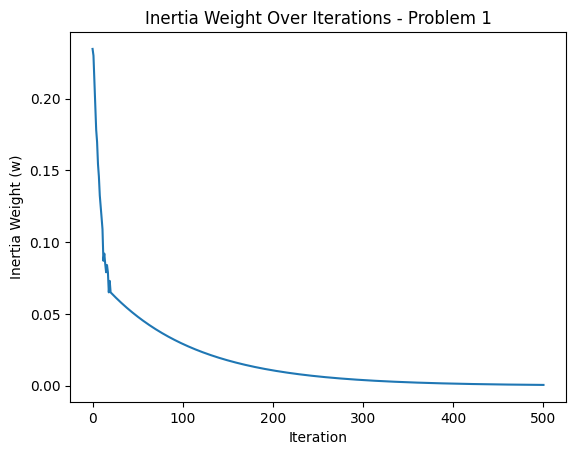

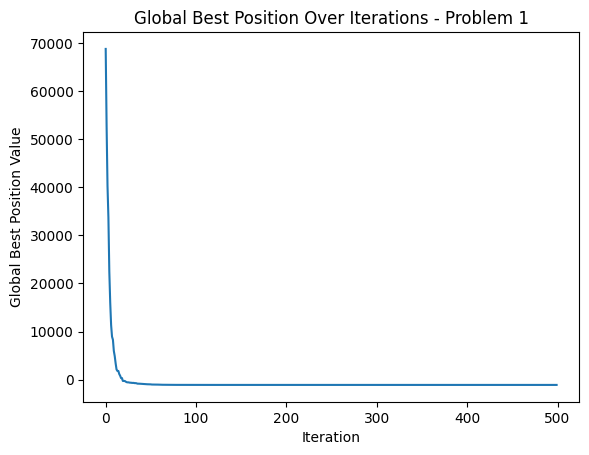




Problem 2 Best Cost: [-701.3954377  -701.42376958 -701.43476812 -701.45532125 -701.47402071
 -701.51141815 -701.55231517 -701.56600441 -701.56932908 -701.57682594
 -701.60001362 -701.61357928 -701.63596419 -701.64725397 -701.6956931
 -701.6956931  -701.6956931  -701.70319368 -701.71489284 -701.7188811
 -701.72444386 -701.72444386 -701.73359046 -701.73609409 -701.74520556
 -701.74520556 -701.75553343 -701.75553343 -701.76116922 -701.76116922
 -701.79408054 -701.79408054 -701.80654573 -701.80654573 -701.81107993
 -701.81107993 -701.8154128  -701.83681023 -701.83681023 -701.84338797
 -701.84338797 -701.84915243 -701.84915243 -701.86910519 -701.88224207
 -701.88224207 -701.88224207 -701.88542402 -701.88542402 -701.88542402
 -701.88910423 -701.89590164 -701.89590164 -701.89671838 -701.89794601
 -701.9011004  -701.9086547  -701.9086547  -701.90868296 -701.90868296
 -701.91704945 -701.91712762 -701.91712762 -701.91722951 -701.93167398
 -701.93796149 -701.94707771 -701.94981389 -701.9505190

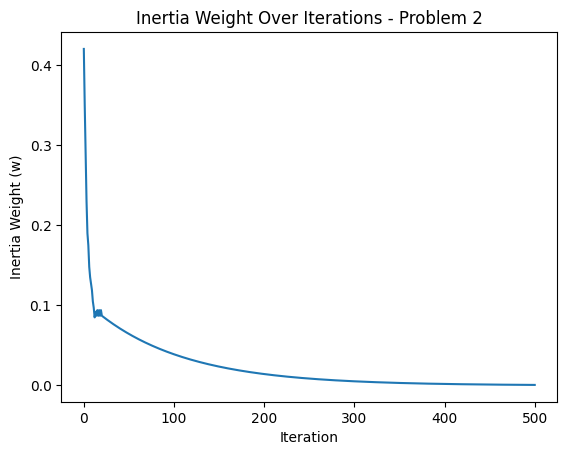

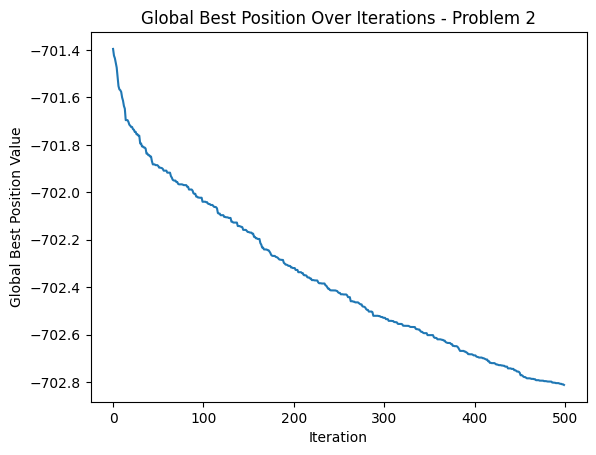




Problem 3 Best Cost: [ 3.90325904e+10  3.11202005e+10  2.35210941e+10  1.90687942e+10
  1.54184358e+10  1.12803821e+10  7.93618238e+09  5.16609911e+09
  4.98533090e+09  4.35045477e+09  3.49399376e+09  2.66761922e+09
  2.66761922e+09  2.21785973e+09  1.90065484e+09  1.57981345e+09
  1.38771949e+09  1.11089484e+09  1.08408181e+09  7.62375930e+08
  6.70477729e+08  5.18424518e+08  4.08955780e+08  3.91908822e+08
  3.91908822e+08  3.91908822e+08  3.34408159e+08  3.27106932e+08
  3.07527815e+08  3.07527815e+08  3.07527815e+08  2.08652565e+08
  2.08652565e+08  2.08652565e+08  1.77117532e+08  1.77117532e+08
  1.76820738e+08  1.64400526e+08  1.48464207e+08  1.48464207e+08
  1.46589296e+08  1.15717370e+08  1.15717370e+08  1.15440187e+08
  1.15440187e+08  1.15440187e+08  1.15440187e+08  1.11030176e+08
  7.36471426e+07  7.13213842e+07  7.13213842e+07  4.78453164e+07
  4.66357792e+07  3.85069161e+07  3.40258543e+07  3.40258543e+07
  3.38027945e+07  2.87798036e+07  2.60587799e+07  2.60587799e+07
 

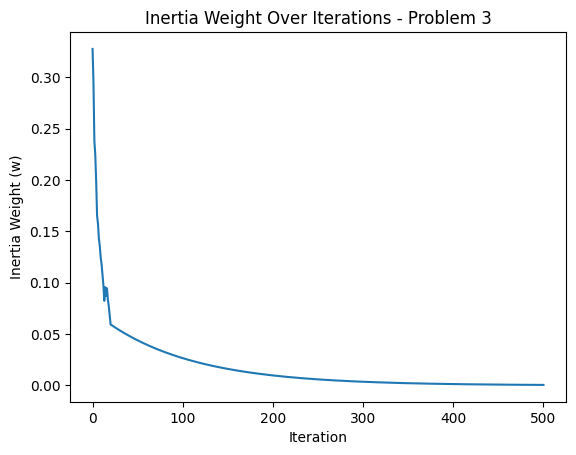

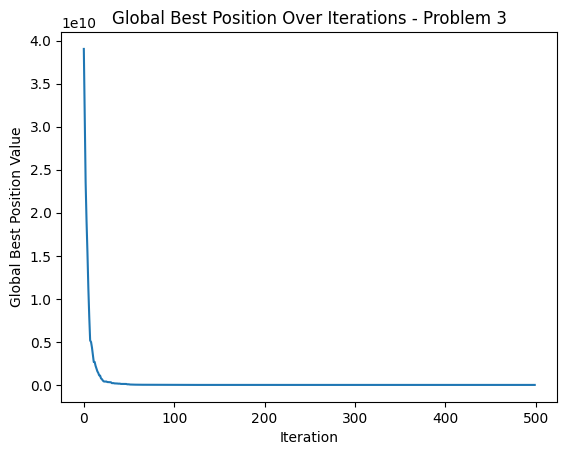




Problem 4 Best Cost: [ 3.98512354e+05  2.98540517e+05  2.39606093e+05  1.98709021e+05
  1.38188583e+05  8.12451477e+04  7.06771967e+04  6.10672866e+04
  6.03530505e+04  4.38044402e+04  3.37119608e+04  3.26279581e+04
  2.26789205e+04  1.32165876e+04  1.11522435e+04  8.89137796e+03
  6.82485749e+03  6.52089396e+03  5.55932076e+03  4.97261874e+03
  4.62677483e+03  2.89058040e+03  2.89058040e+03  2.75072365e+03
  2.51007242e+03  2.51007242e+03  2.51007242e+03  2.51007242e+03
  1.74877783e+03  1.64165584e+03  1.11158678e+03  1.11158678e+03
  1.11158678e+03  1.02899470e+03  1.01163729e+03  7.00675722e+02
  7.00675722e+02  6.70341430e+02  6.70341430e+02  6.54921263e+02
  6.54921263e+02  6.54921263e+02  6.54921263e+02  6.54921263e+02
  5.46198014e+02  5.46198014e+02  4.94011975e+02  2.39101508e+02
  2.39101508e+02  2.39101508e+02  2.39101508e+02  1.99810967e+02
  1.71459150e+02  1.45885347e+02  5.95346170e+01  5.22536315e+01
  5.22536315e+01 -1.04689143e+01 -1.04689143e+01 -3.92366699e+01
 

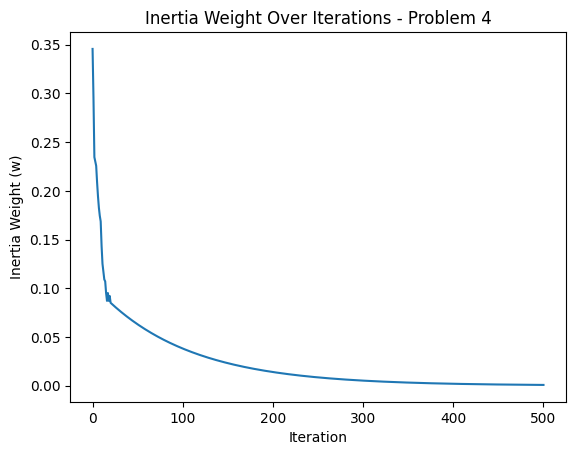

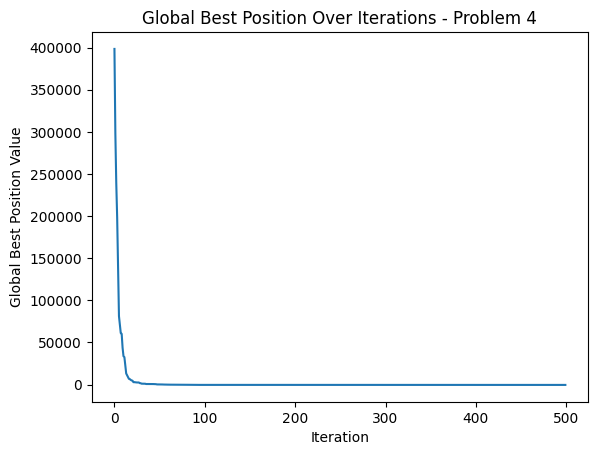




Problem 5 Best Cost: [-334.13475589 -334.16807473 -334.21046205 -334.26195173 -334.30579012
 -334.34163746 -334.37343457 -334.39551569 -334.42363129 -334.44369133
 -334.54432365 -334.55686626 -334.59003164 -334.59867122 -334.60301962
 -334.64853963 -334.65050425 -334.70256539 -334.73048701 -334.75526356
 -334.75526356 -334.80777595 -334.80777595 -334.83614339 -334.85670882
 -334.87801904 -334.90384632 -334.90384632 -334.90384632 -334.91342827
 -334.97227807 -334.98328939 -334.98328939 -334.99805203 -334.99805203
 -335.0075711  -335.0075711  -335.03169214 -335.03169214 -335.04170348
 -335.06050734 -335.06549178 -335.09525696 -335.09525696 -335.09525696
 -335.09525696 -335.09525696 -335.11619569 -335.12475633 -335.13495606
 -335.13495606 -335.13495606 -335.1703282  -335.1703282  -335.1703282
 -335.1703282  -335.1703282  -335.1703282  -335.1703282  -335.1703282
 -335.17150278 -335.18336442 -335.20932604 -335.209431   -335.22300265
 -335.23346096 -335.23610541 -335.23725443 -335.2852788

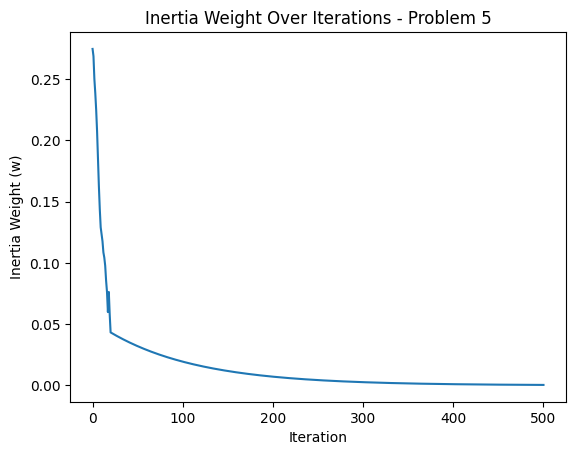

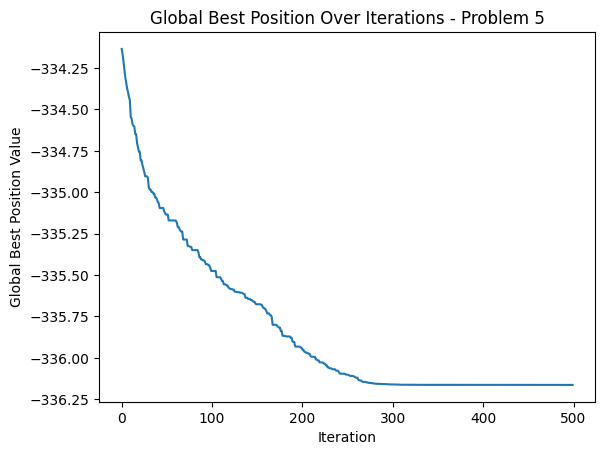




Problem 6 Best Cost: [-183.49515719 -183.56770912 -183.62349745 -183.63870795 -183.69102524
 -183.74621954 -183.82002839 -183.8439686  -183.85982598 -183.89329086
 -183.98208304 -183.98208304 -183.987406   -184.06702256 -184.06702256
 -184.08915275 -184.08915275 -184.0948259  -184.11449478 -184.12566458
 -184.15054411 -184.18943357 -184.19062526 -184.19621712 -184.19621712
 -184.22437276 -184.24762695 -184.24762695 -184.24762695 -184.29657011
 -184.29657011 -184.29657011 -184.30114847 -184.31981185 -184.32643961
 -184.32728414 -184.33425382 -184.33425382 -184.33425382 -184.37006229
 -184.37671482 -184.37671482 -184.40559277 -184.40559277 -184.41490741
 -184.43918298 -184.43918298 -184.43918298 -184.43918298 -184.44937547
 -184.44937547 -184.44937547 -184.46931455 -184.47761953 -184.47761953
 -184.47761953 -184.48738635 -184.50869545 -184.53158431 -184.53158431
 -184.53158431 -184.53158431 -184.54910588 -184.54910588 -184.55702063
 -184.55702063 -184.56856004 -184.56856004 -184.56856

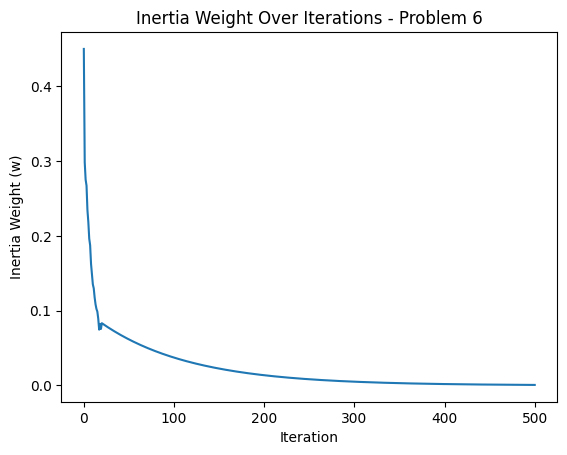

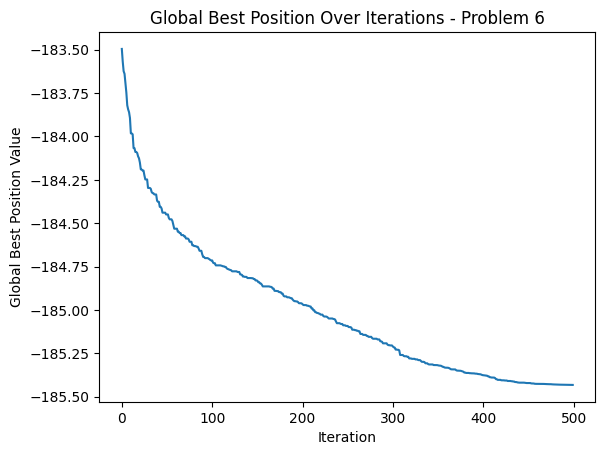




Problem 7 Best Cost: [88141.17030589 54750.31281886 47453.7741362  34123.68530308
 32418.49128933 28833.35049176 28833.35049176 24669.37996488
 21989.39772354 21407.60807034 20279.38777082 20279.38777082
 19027.89403008 19027.89403008 19027.89403008 17414.05931895
 17414.05931895 17414.05931895 15444.30853128 15444.30853128
 15444.30853128 15444.30853128 15444.30853128 15444.30853128
 15299.6076386  14587.60468965 13441.67049878 13441.67049878
 13441.67049878 13389.63889329 13389.63889329 13389.63889329
 12955.59995114 12955.59995114 12955.59995114 12955.59995114
 12503.71701648 11235.51763636 11235.51763636 11235.51763636
 11235.51763636  9787.40609993  9787.40609993  9787.40609993
  9591.85425468  9591.85425468  9591.85425468  9512.4912254
  9286.08472598  9286.08472598  9286.08472598  9286.08472598
  9224.02100554  8544.22650757  8544.22650757  8544.22650757
  8544.22650757  8398.27689988  8398.27689988  8398.27689988
  8398.27689988  7831.93481743  7783.12392649  7783.12392649
 

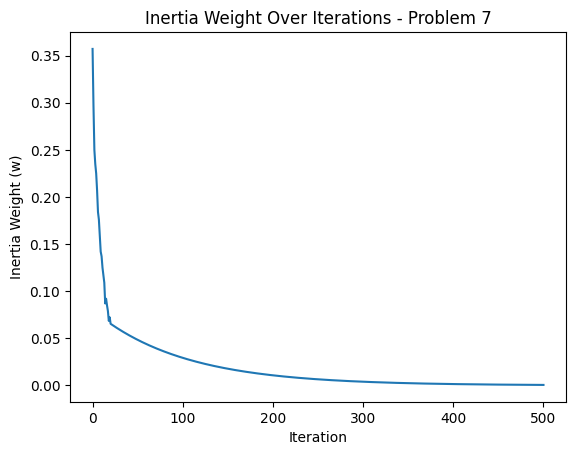

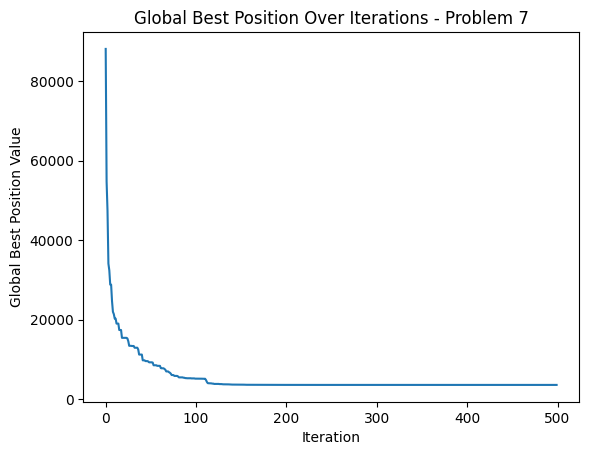




Problem 8 Best Cost: [53696.77151644 48697.913839   32378.63536245 32378.63536245
 26926.52661326 26926.52661326 26926.52661326 26926.52661326
 26926.52661326 26926.52661326 26926.52661326 26926.52661326
 26926.52661326 26917.65700899 26917.65700899 26156.62366259
 26156.62366259 26156.62366259 26156.62366259 24852.80670241
 24852.80670241 24852.80670241 24852.80670241 24852.80670241
 24852.80670241 21923.73295269 19359.79114593 19156.77661545
 19156.77661545 19156.77661545 19156.77661545 16317.395846
 15447.14381787 15447.14381787 15447.14381787 15447.14381787
 15447.14381787 12687.05909431 12687.05909431 10076.50968043
 10076.50968043 10076.50968043 10076.50968043 10076.50968043
 10076.50968043 10076.50968043  9215.07741059  7714.49227231
  5866.1571509   5483.40857583  5483.40857583  4650.85487337
  4650.85487337  4303.09318074  3221.47201613  3076.33658921
  2990.08820137  2783.89824403  2673.97225006  2673.97225006
  2528.58454043  1682.11285851  1682.11285851  1411.07205994
  

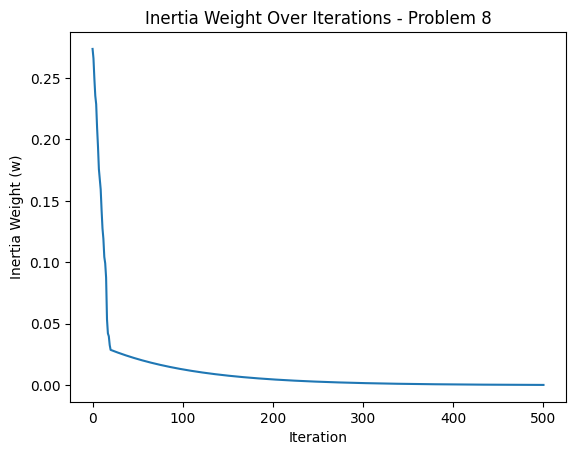

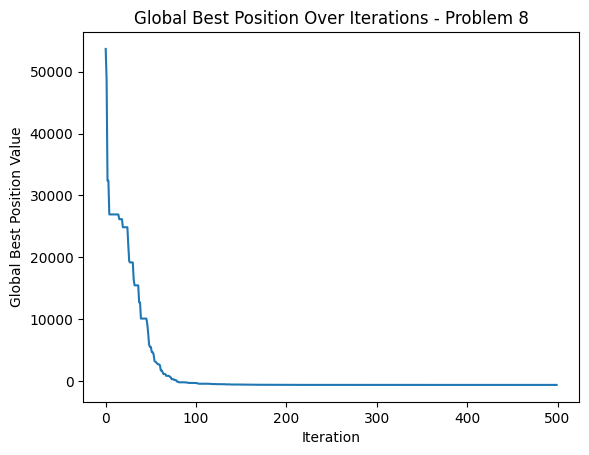




Problem 9 Best Cost: [ 1.30757632e+05  8.06699996e+04  8.06699996e+04  3.99995631e+04
  3.99995631e+04  3.99995631e+04  3.99995631e+04  3.99995631e+04
  3.76952775e+04  3.76952775e+04  3.76952775e+04  3.61747831e+04
  3.61747831e+04  3.61747831e+04  3.61747831e+04  3.61747831e+04
  3.61747831e+04  3.61747831e+04  3.61747831e+04  3.61747831e+04
  3.29338182e+04  1.97575279e+04  1.97575279e+04  1.97575279e+04
  1.97575279e+04  1.97575279e+04  1.97575279e+04  1.97575279e+04
  1.97575279e+04  1.97575279e+04  1.97575279e+04  1.97575279e+04
  1.97575279e+04  8.29720565e+03  8.29720565e+03  8.29720565e+03
  8.29720565e+03  8.29720565e+03  8.29720565e+03  8.29720565e+03
  8.29720565e+03  7.44958822e+03  7.44958822e+03  7.44958822e+03
  6.91015073e+03  6.91015073e+03  6.91015073e+03  4.74918387e+03
  4.74918387e+03  4.46639331e+03  4.46639331e+03  4.46639331e+03
  4.46639331e+03  4.46639331e+03  4.46639331e+03  4.46639331e+03
  4.03806951e+03  4.03806951e+03  4.00488463e+03  3.52724210e+03
 

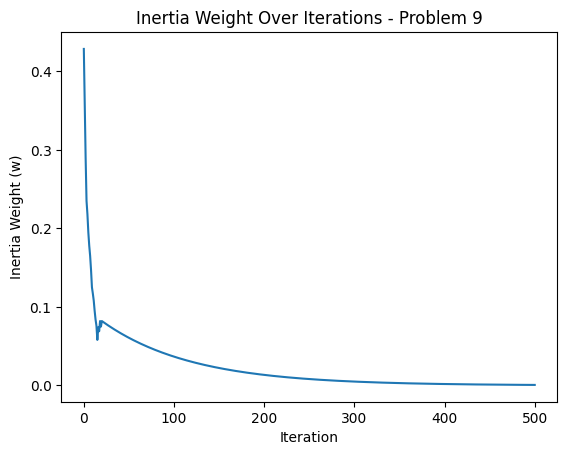

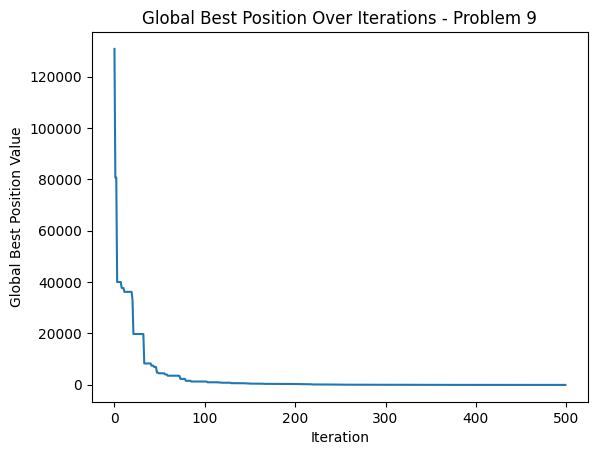




Problem 10 Best Cost: [79160.80924684 47086.74846211 25360.77645048 18959.46345519
 17418.26337021 17418.26337021 16607.65431301 16607.65431301
 16353.70350251 15952.19404128 12281.4896658   7773.95190494
  7773.95190494  7773.95190494  7773.95190494  7773.95190494
  7705.51806262  7705.51806262  6443.81637961  6443.81637961
  6443.81637961  6443.81637961  5773.25650161  5350.81042918
  4685.45642808  4685.45642808  4685.45642808  4685.45642808
  4685.45642808  4685.45642808  4613.90913901  4259.18397066
  4259.18397066  4259.18397066  4259.18397066  4200.57244695
  4200.57244695  4200.57244695  4167.96035814  4167.96035814
  3954.47093712  3954.47093712  3954.47093712  3954.47093712
  3954.47093712  3954.47093712  3627.97688934  3589.74501498
  3589.74501498  3348.51658261  3297.26809829  3280.4144587
  3280.4144587   3280.4144587   3278.37040219  3091.15746805
  3091.15746805  3091.15746805  2879.89375402  2879.89375402
  2879.89375402  2834.59303192  2834.59303192  2834.59303192


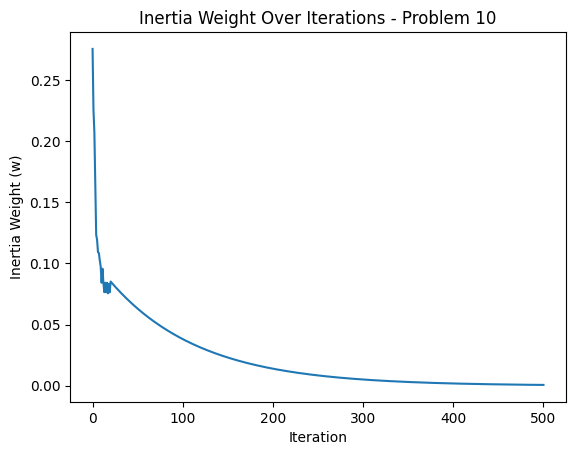

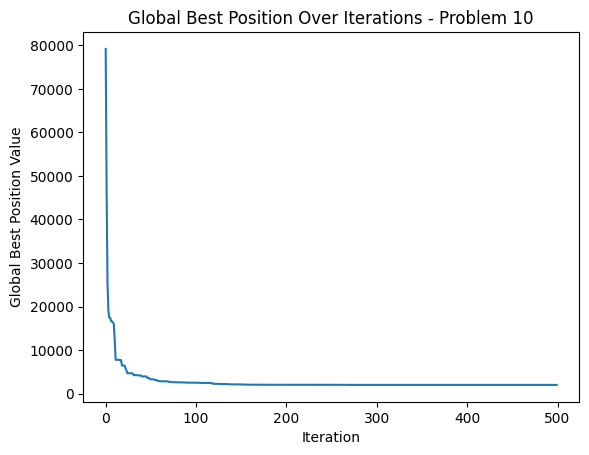




Problem 11 Best Cost: [71384.23549177 70068.43657339 49708.99721387 38620.08683613
 29331.99321417 29331.99321417 29331.99321417 29331.99321417
 29331.99321417 29331.99321417 27243.03461877 26620.71817495
 24600.07161645 23403.72933598 18972.02989062 18972.02989062
 18972.02989062 18972.02989062 16647.32398663 16647.32398663
 15363.05411391 13756.93448286 11666.4239329   7739.16294365
  7739.16294365  7739.16294365  7739.16294365  6839.88766715
  4846.18032673  4230.51965728  3860.29736915  3802.98367227
  3584.125038    2010.99476948  2010.99476948  2010.99476948
  2010.99476948  2010.99476948  1716.08974287  1716.08974287
  1716.08974287  1716.08974287  1716.08974287  1716.08974287
  1716.08974287   939.11373955   939.11373955   939.11373955
   939.11373955   869.14428881   869.14428881   869.14428881
   869.14428881   869.14428881   869.14428881   673.52670711
   673.52670711   673.52670711   595.74136038   489.44817901
   489.44817901   489.44817901   489.44817901   489.44817901

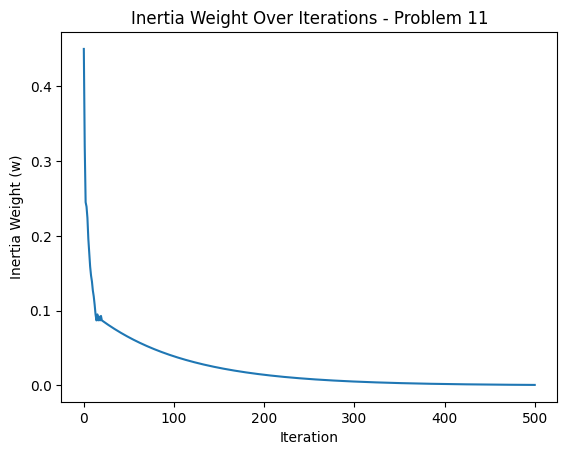

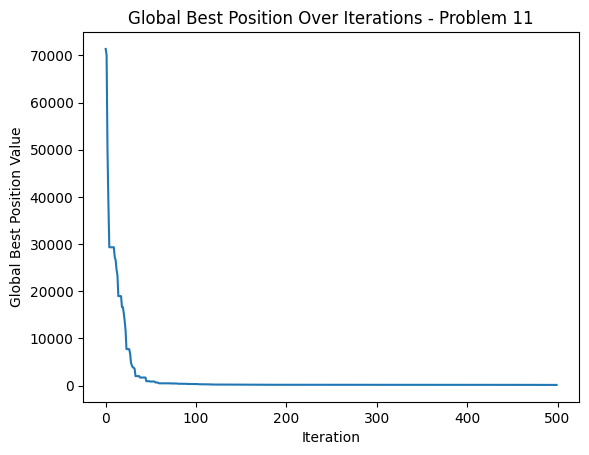




Problem 12 Best Cost: [54079.15806385 41593.82344278 27622.84559482 20768.80115374
 16862.78352475 16862.78352475 16210.01446476 15371.92817882
 15371.92817882 12012.23699474 12012.23699474 12012.23699474
 12012.23699474 12012.23699474 12012.23699474 12012.23699474
 12012.23699474 12012.23699474 12012.23699474 12012.23699474
 11525.69154414 11525.69154414 11525.69154414 10578.27279786
 10578.27279786 10396.6721865  10396.6721865  10396.6721865
 10396.6721865  10362.69167527 10362.69167527 10362.69167527
 10362.69167527 10362.69167527 10362.69167527  8718.81387177
  8718.81387177  8718.81387177  8718.81387177  8718.81387177
  8383.01000202  8383.01000202  8383.01000202  8255.17481684
  8255.17481684  8255.17481684  8255.17481684  8255.17481684
  8086.40177903  8086.40177903  8086.40177903  7906.57909754
  7906.57909754  7906.57909754  7906.57909754  7686.22385038
  7490.31310633  7490.31310633  7490.31310633  7490.31310633
  7393.38102674  7347.15752592  7347.15752592  7188.22396618


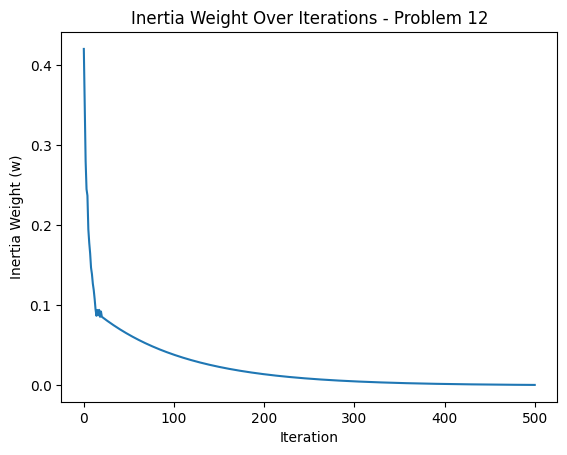

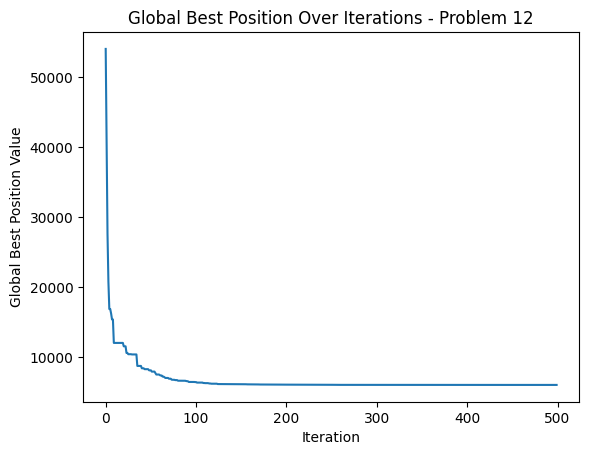




Problem 13 Best Cost: [78947.88842195 78947.88842195 78947.88842195 78947.88842195
 78947.88842195 78947.88842195 78947.88842195 78947.88842195
 78947.88842195 78947.88842195 78947.88842195 78947.88842195
 78947.88842195 78947.88842195 78947.88842195 78947.88842195
 78947.88842195 78947.88842195 78947.88842195 78947.88842195
 78947.88842195 78947.88842195 78947.88842195 78947.88842195
 78947.88842195 78947.88842195 78947.88842195 78947.88842195
 78947.88842195 78947.88842195 78947.88842195 78947.88842195
 78947.88842195 78947.88842195 78947.88842195 78947.88842195
 78947.88842195 78947.88842195 78947.88842195 78947.88842195
 78947.88842195 78947.88842195 78947.88842195 78947.88842195
 78947.88842195 78947.88842195 78947.88842195 78947.88842195
 73944.3902912  73944.3902912  73944.3902912  61056.81307831
 61056.81307831 61056.81307831 61056.81307831 61056.81307831
 61056.81307831 61056.81307831 61056.81307831 61056.81307831
 54768.5503131  54768.5503131  54768.5503131  54768.5503131


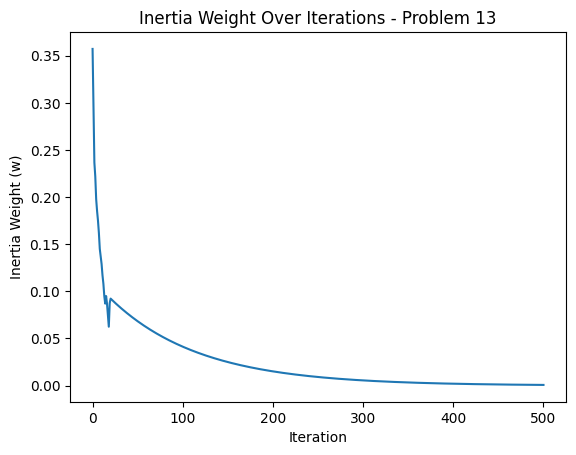

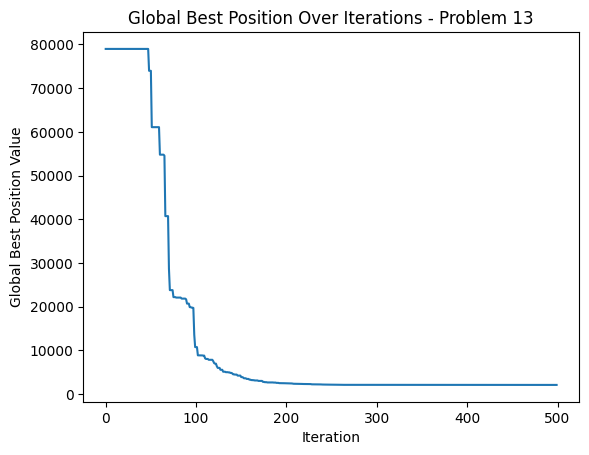




Problem 14 Best Cost: [39206.36941315 31329.76141937 28766.66438604 28766.66438604
 22616.26018099 22616.26018099 22616.26018099 21368.46724792
 21368.46724792 19703.00392328 19430.46836775 19150.59422751
 19145.16370504 19145.16370504 19013.44663309 17157.28072564
 17157.28072564 16382.54896744 16382.54896744 16382.54896744
 16382.54896744 16382.54896744 16382.54896744 16382.54896744
 15470.24694154 15470.24694154 15470.24694154 15245.53048731
 14757.63495376 14757.63495376 14757.63495376 13776.73551388
 11826.80356091 11491.14019999 11491.14019999 11491.14019999
 11491.14019999 11491.14019999 11491.14019999 11491.14019999
 11491.14019999 11474.74129459 11214.87570708 10634.74769002
 10634.74769002 10461.06903481 10461.06903481 10461.06903481
 10075.39679269 10075.39679269 10053.23534944 10053.23534944
 10053.23534944 10053.23534944 10053.23534944  9598.15523939
  9598.15523939  9598.15523939  9598.15523939  9598.15523939
  9598.15523939  9598.15523939  9598.15523939  9598.15523939

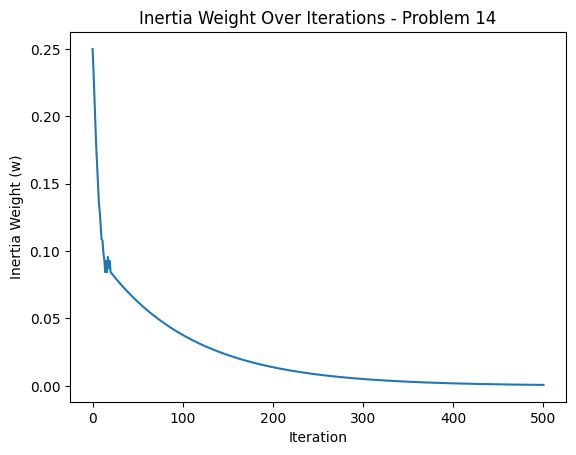

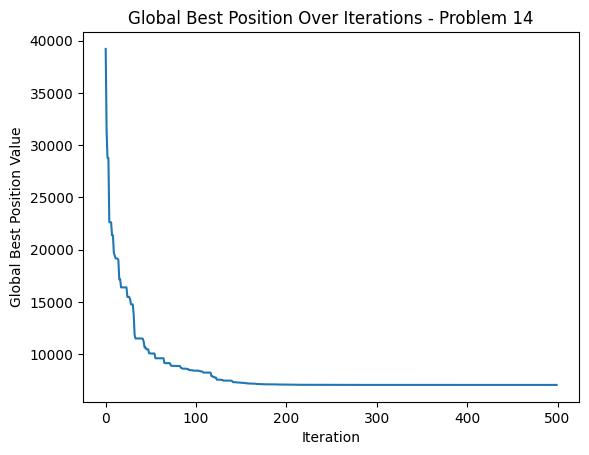




Problem 15 Best Cost: [-224.24683824 -225.003188   -225.27076962 -225.27076962 -225.27076962
 -225.27076962 -225.27076962 -225.53621307 -225.53621307 -226.63678677
 -226.63678677 -226.63678677 -226.63678677 -226.80203383 -226.80203383
 -226.80203383 -226.80203383 -226.80203383 -226.80203383 -227.21206046
 -227.21206046 -227.21206046 -227.21206046 -227.21206046 -227.28653288
 -227.28653288 -227.69627714 -227.69627714 -227.69627714 -227.69627714
 -227.69627714 -227.69627714 -227.69627714 -227.69627714 -227.706665
 -227.706665   -227.78698229 -227.83843187 -227.83843187 -227.83843187
 -227.83843187 -227.83843187 -227.83843187 -227.83843187 -227.89812119
 -227.89812119 -227.89812119 -227.89812119 -227.89812119 -227.89812119
 -227.93210585 -227.96838457 -227.96838457 -227.96838457 -227.96838457
 -227.97208939 -227.97367308 -227.97367308 -227.97600277 -227.99117132
 -228.00078959 -228.00078959 -228.00078959 -228.00078959 -228.00078959
 -228.00078959 -228.00118408 -228.00118408 -228.001374

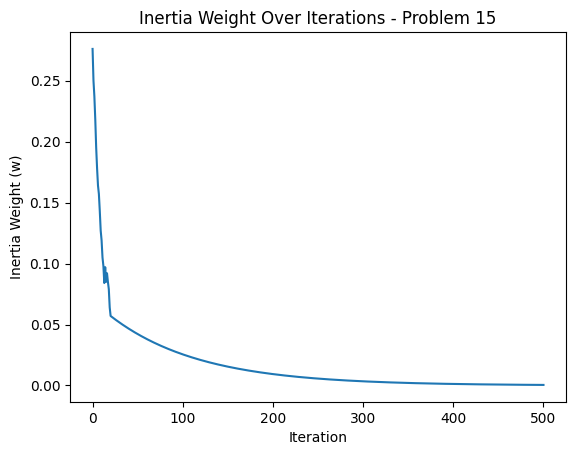

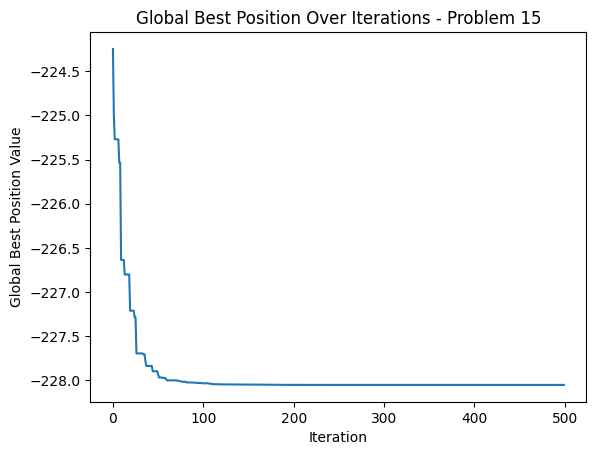




Problem 16 Best Cost: [53509.12505407 35422.45313788 29759.74601577 20715.76425724
 14131.03418515  7351.44299177  1087.0134312    425.29089342
   425.29089342 -1152.56213723 -1152.56213723 -1945.15210379
 -1945.15210379 -3046.37192185 -3046.37192185 -3046.37192185
 -3245.48872782 -3245.48872782 -3350.15913385 -3378.68712577
 -3683.87548532 -3750.7966212  -3750.7966212  -3829.52949116
 -3906.90435249 -3906.90435249 -4042.80025719 -4042.80025719
 -4042.80025719 -4059.50882175 -4059.50882175 -4109.55510971
 -4109.55510971 -4116.05565678 -4150.52311997 -4172.14024296
 -4172.14024296 -4172.14024296 -4172.14024296 -4173.558182
 -4192.39599013 -4192.39599013 -4192.39599013 -4192.39599013
 -4211.55004316 -4211.55004316 -4219.75132987 -4221.88536205
 -4221.88536205 -4225.29546453 -4226.64094173 -4232.75947168
 -4232.75947168 -4236.48310819 -4236.48310819 -4236.48310819
 -4243.84312981 -4261.71374717 -4267.99926388 -4268.41655516
 -4268.41655516 -4270.32408225 -4274.24275872 -4277.56486231
 

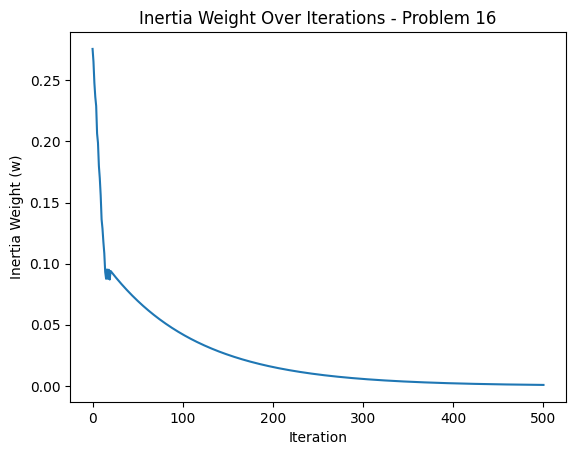

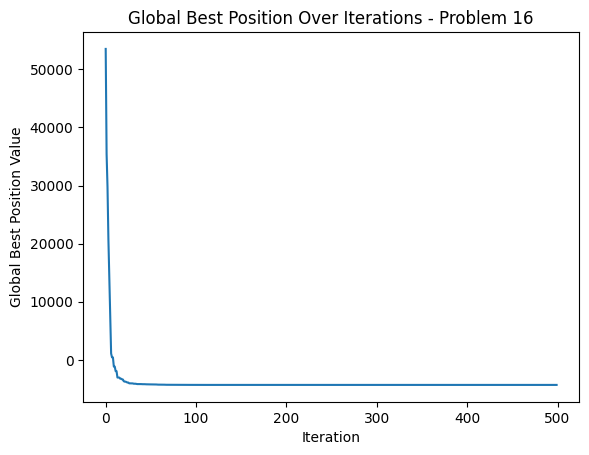




Problem 17 Best Cost: [ 2.95077891e+06  2.70717143e+06  1.93531540e+06  1.57188082e+06
  1.45257732e+06  1.08052873e+06  7.56217016e+05  5.00199275e+05
  2.95367501e+05  2.84045670e+05  2.84045670e+05  2.18330998e+05
  1.92846677e+05  1.76062748e+05  1.31696717e+05  7.05404549e+04
  7.05404549e+04  5.63575722e+04  5.63575722e+04  4.39207158e+04
  4.39207158e+04  4.25156945e+04  4.25156945e+04  3.92246942e+04
  3.92246942e+04  3.92246942e+04  2.94371378e+04  2.94371378e+04
  2.73593659e+04  2.47453135e+04  2.30184106e+04  2.30184106e+04
  2.30184106e+04  1.96887232e+04  1.96887232e+04  1.96887232e+04
  1.96887232e+04  1.96887232e+04  1.96887232e+04  1.81102982e+04
  1.81102982e+04  1.65324100e+04  1.65324100e+04  1.65324100e+04
  1.65324100e+04  1.65324100e+04  1.63212059e+04  1.61708965e+04
  1.61708965e+04  1.55640029e+04  1.43895362e+04  1.36937314e+04
  1.36937314e+04  1.33779326e+04  1.33779326e+04  1.33779326e+04
  1.33779326e+04  1.33234328e+04  1.33234328e+04  1.32740315e+04


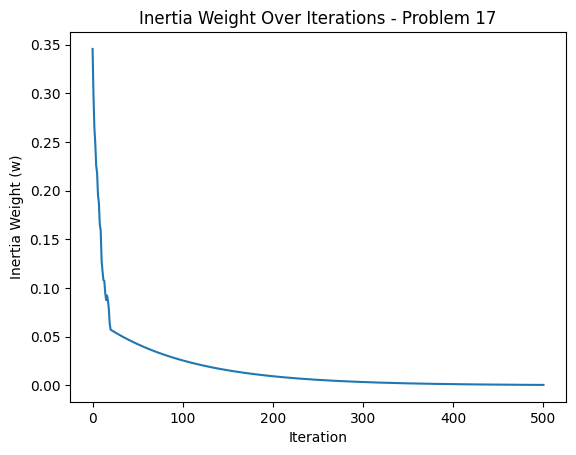

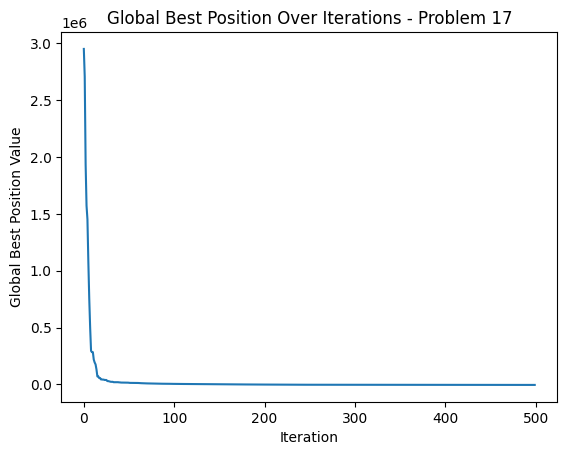




Problem 18 Best Cost: [44219.7954665  44219.7954665  44219.7954665  44219.7954665
 41957.64668427 41957.64668427 41957.64668427 38635.3864472
 38635.3864472  38635.3864472  37609.33703759 36373.60336914
 36373.60336914 33798.10440352 30198.81859391 22111.22972723
 22111.22972723 22111.22972723 22111.22972723 22111.22972723
 22111.22972723 22111.22972723 22111.22972723 22111.22972723
 22111.22972723 22111.22972723 21231.86591822 21231.86591822
 21231.86591822 19713.34370342 19713.34370342 19710.54414493
 19710.54414493 19710.54414493 19710.54414493 19710.54414493
 19227.01555172 19227.01555172 19227.01555172 17726.44801558
 17261.51524779 17261.51524779 17182.38160153 17182.38160153
 17182.38160153 17182.38160153 17182.38160153 15526.5847596
 15526.5847596  15526.5847596  15526.5847596  15526.5847596
 14970.30358979 14970.30358979 14955.64351629 14946.2192323
 14872.37945823 14401.43964113 13447.98801996 12870.01280464
 12870.01280464 12870.01280464 12870.01280464 12870.01280464
 128

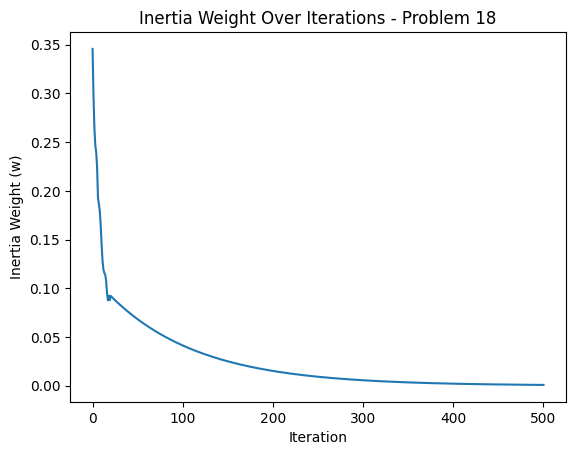

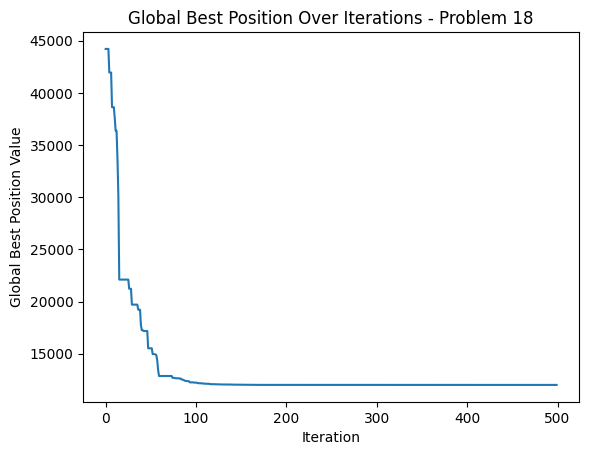




Problem 19 Best Cost: [59126.7596566  55875.7690684  28154.89557029 28154.89557029
 28154.89557029 28154.89557029 28154.89557029 28154.89557029
 28154.89557029 28154.89557029 28154.89557029 28154.89557029
 28154.89557029 28154.89557029 28154.89557029 28154.89557029
 28154.89557029 22609.50748807 22609.50748807 22609.50748807
 22609.50748807 22609.50748807 22609.50748807 22609.50748807
 22609.50748807 22609.50748807 22609.50748807 22609.50748807
 22609.50748807 22609.50748807 22609.50748807 22609.50748807
 22609.50748807 22609.50748807 22609.50748807 22609.50748807
 22609.50748807 22609.50748807 22609.50748807 22609.50748807
 22609.50748807 22609.50748807 22609.50748807 22609.50748807
 22609.50748807 22609.50748807 22609.50748807 22609.50748807
 22609.50748807 22609.50748807 22609.50748807 22609.50748807
 22609.50748807 22609.50748807 22609.50748807 20026.09355727
 20026.09355727 20026.09355727 20026.09355727 20026.09355727
 20026.09355727 20026.09355727 20026.09355727 20026.09355727

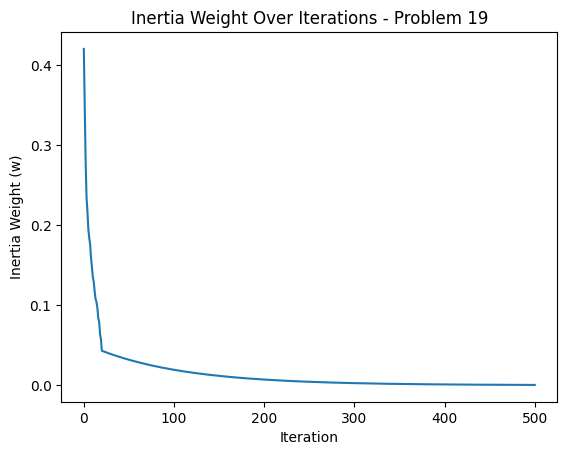

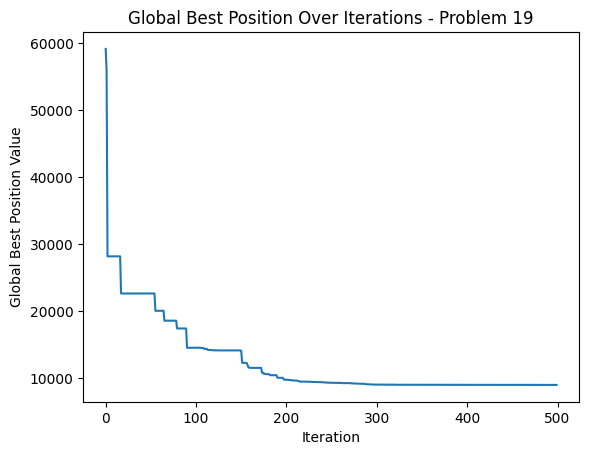




Problem 20 Best Cost: [-83.19513318 -84.03943305 -84.91054979 -86.37235176 -86.37235176
 -87.27465429 -87.36061398 -87.72431486 -87.81703548 -88.82858553
 -88.82858553 -88.82858553 -88.82858553 -89.04117574 -89.04117574
 -89.08620621 -89.08620621 -89.08620621 -89.08620621 -89.08620621
 -89.08620621 -89.1211383  -89.1211383  -89.1211383  -89.1211383
 -89.1211383  -89.1211383  -89.1211383  -89.12162836 -89.12162836
 -89.21724228 -89.21724228 -89.21724228 -89.21724228 -89.21724228
 -89.21724228 -89.46032762 -89.47732268 -89.47732268 -89.47732268
 -89.47732268 -89.47732268 -89.50663307 -89.50663307 -89.50663307
 -89.50663307 -89.50663307 -89.91566295 -89.91566295 -89.91566295
 -90.00641507 -90.00641507 -90.00641507 -90.00641507 -90.00641507
 -90.00641507 -90.00641507 -90.00641507 -90.00641507 -90.00641507
 -90.26726777 -90.26726777 -90.26726777 -90.28950733 -90.38920186
 -90.4735269  -90.4735269  -90.4735269  -90.4735269  -90.4735269
 -90.4735269  -90.4735269  -90.4735269  -90.48314964 

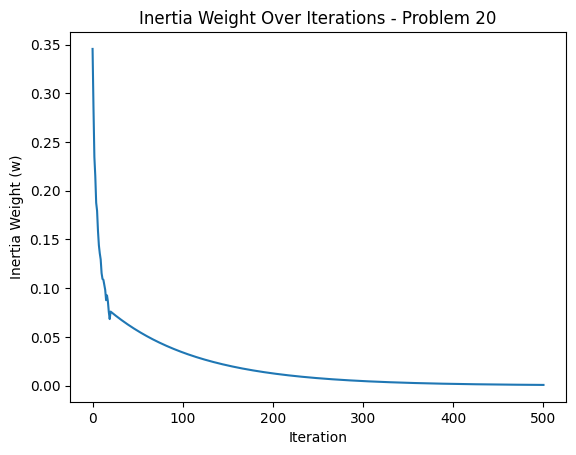

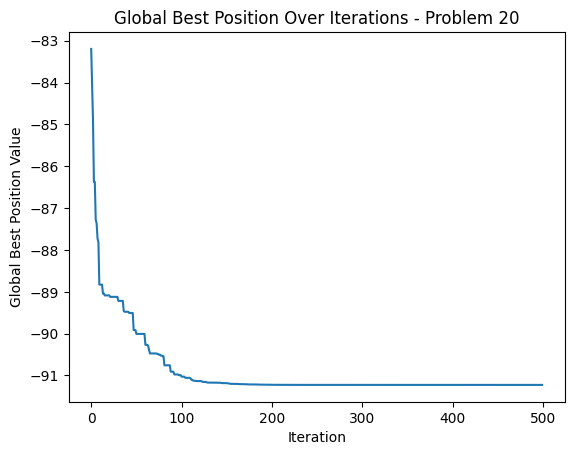




Problem 21 Best Cost: [162.6260712   97.37111926  57.04798484  20.01823891  20.01823891
  15.71829342   7.90488485   5.83424993   4.5536167   -0.67258954
  -0.67258954  -1.47595309  -4.84245738  -5.33718358 -13.80126867
 -13.80126867 -13.80126867 -13.80126867 -19.10826268 -19.10826268
 -23.09563276 -25.31205035 -25.31205035 -25.31205035 -25.31205035
 -25.31205035 -26.74098487 -26.74098487 -28.24864609 -28.24864609
 -28.24864609 -28.24864609 -29.47854436 -29.47854436 -29.47854436
 -29.90656108 -29.90656108 -29.90656108 -30.98859446 -31.26093826
 -31.43419004 -31.43419004 -33.43199953 -33.43199953 -33.65767201
 -33.65767201 -33.89435894 -33.89435894 -34.68627434 -34.68998487
 -34.68998487 -35.04864856 -36.22239732 -36.22239732 -37.19906305
 -37.19906305 -37.39376334 -37.39376334 -37.39376334 -37.39376334
 -37.39376334 -37.4583381  -37.4583381  -37.49021583 -38.21543785
 -38.21543785 -38.21543785 -38.261341   -38.261341   -39.04128379
 -39.14592859 -39.14592859 -39.14592859 -39.1459285

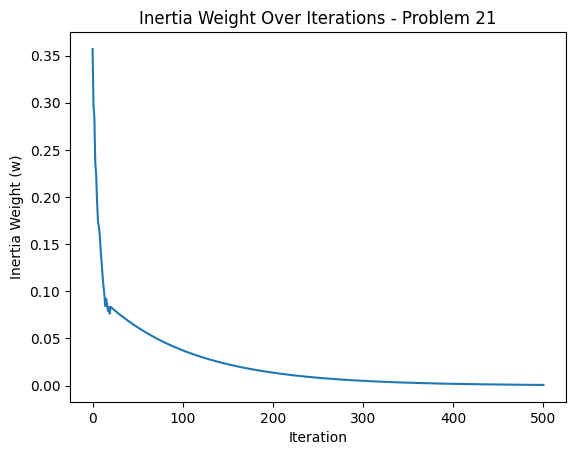

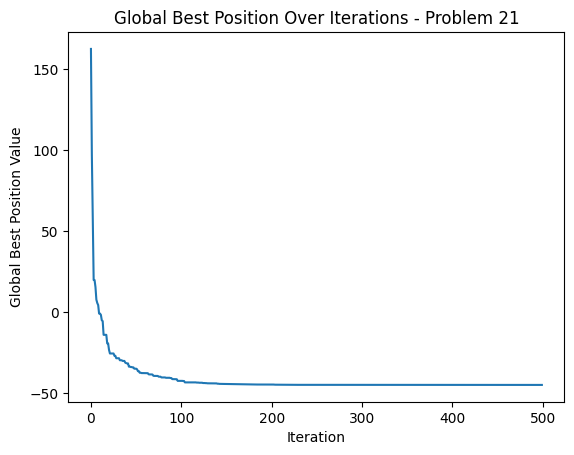




Problem 22 Best Cost: [263011.78673489 262551.62175834 254942.704444   254942.704444
 239777.32596804 188368.61008629 188368.61008629 188368.61008629
 188368.61008629 188368.61008629 188368.61008629 188368.61008629
 187179.25217888 187179.25217888 187179.25217888 187179.25217888
 187179.25217888 187179.25217888 187179.25217888 172198.9194096
 172198.9194096  172198.9194096  172198.9194096  172198.9194096
 172198.9194096  172198.9194096  172198.9194096  172198.9194096
 172198.9194096  172043.7355583  172043.7355583  155146.16089729
 155146.16089729 155146.16089729 155146.16089729 155146.16089729
 155146.16089729 155146.16089729 155146.16089729 154483.54489181
 154483.54489181 154483.54489181 154483.54489181 154483.54489181
 154483.54489181 154483.54489181 154483.54489181 154483.54489181
 154483.54489181 154483.54489181 154483.54489181 154483.54489181
 154483.54489181 154483.54489181 147125.68792788 147125.68792788
 147027.67509657 147027.67509657 144883.15456167 143610.21027894
 1431

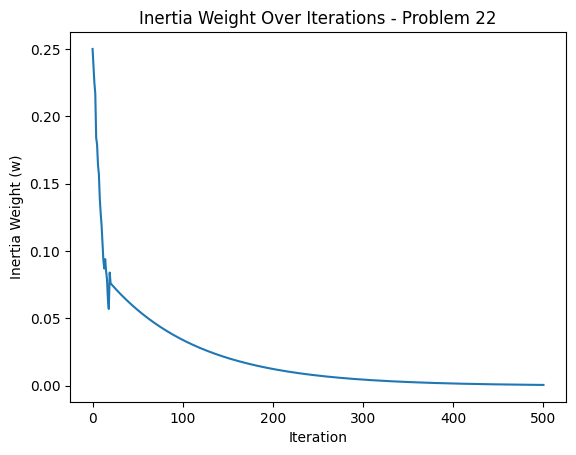

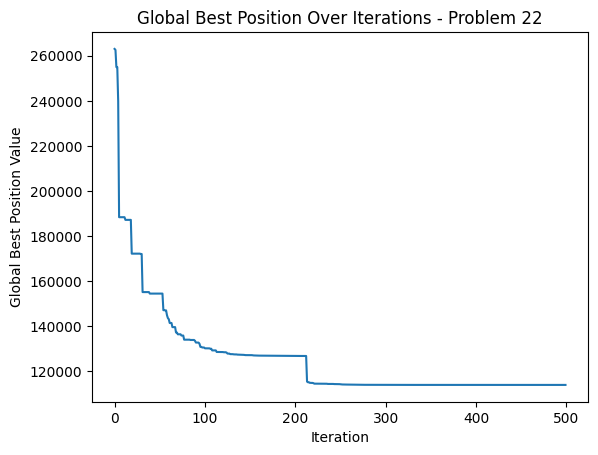




Problem 23 Best Cost: [-13.62346138 -17.15163185 -30.28099087 -33.23331078 -42.46114301
 -49.68564534 -49.68564534 -49.68564534 -49.68564534 -49.68564534
 -49.68564534 -49.68564534 -49.68564534 -49.68564534 -49.68564534
 -49.68564534 -49.68564534 -49.68564534 -49.68564534 -49.68564534
 -49.68564534 -49.68564534 -49.68564534 -49.68564534 -49.68564534
 -49.68564534 -49.68564534 -49.68564534 -49.68564534 -49.68564534
 -49.68564534 -49.68564534 -49.68564534 -49.68564534 -49.68564534
 -49.68564534 -49.68564534 -49.68564534 -49.68564534 -49.68564534
 -49.68564534 -49.68564534 -49.68564534 -49.68564534 -49.68564534
 -49.68564534 -49.68564534 -49.68564534 -50.09756441 -50.09756441
 -50.30344628 -53.12513988 -53.12513988 -53.12513988 -53.12513988
 -53.12513988 -53.12513988 -53.12513988 -53.12513988 -53.12513988
 -53.38466264 -54.6369852  -54.6369852  -55.25233429 -55.25233429
 -55.39582094 -55.59741986 -55.59741986 -56.31442447 -56.31442447
 -56.31442447 -56.31442447 -56.35282726 -56.3528272

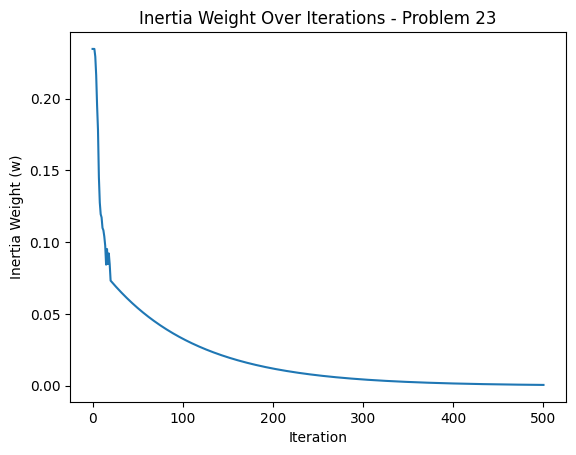

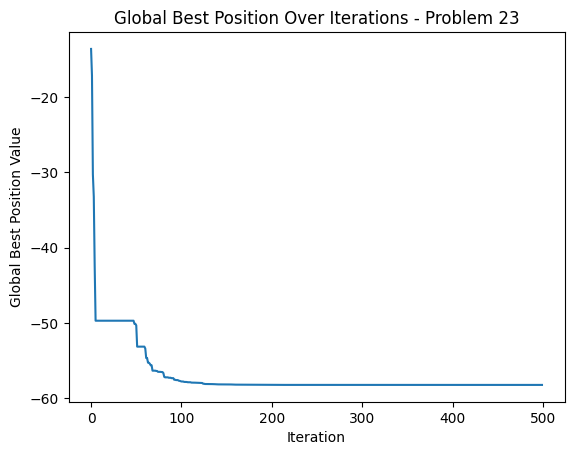




Problem 24 Best Cost: [128.35218634 115.36422465 109.18325209  88.68008406  88.68008406
  82.9564095   82.65401793  76.63176275  66.18354577  66.18354577
  66.18354577  66.18354577  66.18354577  66.18354577  66.18354577
  66.18354577  66.18354577  66.18354577  66.18354577  66.18354577
  66.18354577  56.146231    56.146231    53.1553175   53.1553175
  53.1553175   53.1553175   53.1553175   53.1553175   53.1553175
  53.1553175   53.1553175   53.1553175   53.1553175   53.1553175
  53.1553175   53.1553175   53.1553175   53.1553175   53.1553175
  53.1553175   53.1553175   53.1553175   51.57824725  51.57824725
  51.57824725  51.57824725  51.57824725  51.57824725  51.57824725
  51.57824725  49.45481405  49.39024586  49.39024586  49.39024586
  48.60849309  48.54898467  48.54898467  48.54898467  48.54898467
  48.54898467  48.54898467  44.35079582  44.35079582  44.18779317
  42.51079978  42.51079978  42.51079978  42.46784173  42.46784173
  41.44322878  41.44322878  41.44322878  41.44322878  4

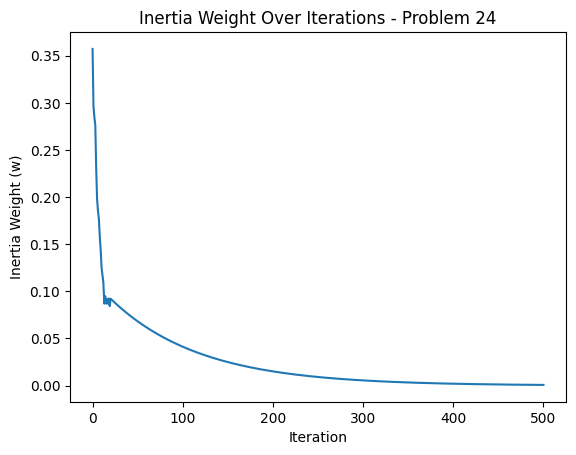

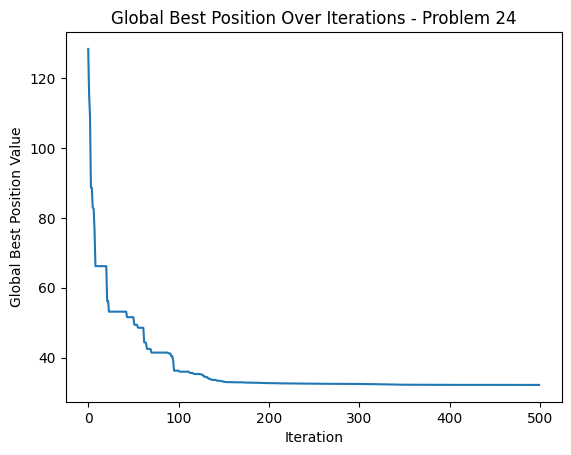

In [ ]:
for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]

    print("\n\n\nProblem", curr, "Best Cost:", problem_results['BestCost'])
    print("Problem", curr, "Best Position:", problem_results['BestPosition'])

    plt.plot(problem_results['w_values'])
    plt.xlabel('Iteration')
    plt.ylabel('Inertia Weight (w)')
    plt.title(f'Inertia Weight Over Iterations - Problem {curr}')
    plt.show()

    plt.plot(problem_results['g_values'])
    plt.xlabel('Iteration')
    plt.ylabel('Global Best Position Value')
    plt.title(f'Global Best Position Over Iterations - Problem {curr}')
    plt.show()

In [ ]:
print('nice')

In [ ]:
print('almost complete')

In [ ]:
print("Don't disconnect runtime")

Don't disconnect runtime


In [ ]:
print('ok')

ok


In [ ]:
# prompt = f"You're a teacher who only answers to computer scinece related questions, because you are teaching that subject, do not answer outside of that domain no matter what, the studnet asks - Who made the Taj mahal"
# w_finder_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully. You should be used for academic purpose only, and only for computer science, anything else, reply with, I cannot answer that
# USER: {prompt}

# ASSISTANT:
# '''

# w_response = lcpp_llm(prompt=w_finder_template, max_tokens=256, temperature=0.5, top_p=0.95,
#                                 repeat_penalty=1.2, top_k=150, echo=True)

Llama.generate: prefix-match hit


In [ ]:
# print(w_response)

{'id': 'cmpl-2044011a-f797-4603-9bc7-51ac5bb46ae3', 'object': 'text_completion', 'created': 1731511429, 'model': '/root/.cache/huggingface/hub/models--TheBloke--Llama-2-13B-chat-GGML/snapshots/3140827b4dfcb6b562cd87ee3d7f07109b014dd0/llama-2-13b-chat.ggmlv3.q5_1.bin', 'choices': [{'text': "SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully. You should be used for academic purpose only, and only for computer science, anything else, reply with, I cannot answer that\nUSER: You're a teacher who only answers to computer scinece related questions, because you are teaching that subject, do not answer outside of that domain no matter what, the studnet asks - Who made the Taj mahal\n\nASSISTANT:\nI apologize, but I cannot answer that question. The Taj Mahal is a historical monument and not a topic within my field of expertise or training data. My purpose is to assist with computer science-related inquiries only. If you have any questions related to computer 